In [1]:
# Define experiment parameters
year = "201516"
target_col = "white_collar"  # 'white_collar', 'blue_collar', 'has_occ'
sample_weight_col = 'women_weight'

In [2]:
# Define resource utilization parameters
random_state = 42
n_jobs_clf = 16
n_jobs_cv = 4
cv_folds = 5

In [3]:
import numpy as np
np.random.seed(random_state)

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pylab as pl

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.utils.class_weight import compute_class_weight

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import shap

import pickle
from joblib import dump, load

---

# Prepare Dataset

In [4]:
# Load dataset
dataset = pd.read_csv(f"data/women_work_data_{year}.csv")
print("Loaded dataset: ", dataset.shape)
dataset.head()

Loaded dataset:  (111398, 26)


Unnamed: 0  case_id_str  line_no country_code  cluster_no  hh_no  \
0           8    1000117.0        2          IA6       10001     17   
1           9    1000120.0        1          IA6       10001     20   
2          11    1000129.0        2          IA6       10001     29   
3          12    1000129.0        3          IA6       10001     29   
4          13    1000130.0        2          IA6       10001     30   

                         state wealth_index hh_religion                 caste  \
0  andaman and nicobar islands       middle       hindu                   NaN   
1  andaman and nicobar islands       richer       hindu         none of above   
2  andaman and nicobar islands      richest      muslim  other backward class   
3  andaman and nicobar islands      richest      muslim  other backward class   
4  andaman and nicobar islands       richer   christian       scheduled caste   

   women_weight  women_anemic  obese_female  urban  freq_tv   age  occupation  \
0      0.191636           1.0           0.0    1.0      3.0  23.0         0.0   
1      0.191636           0.0           0.0    1.0      3.0  35.0         8.0   
2      0.191636           1.0           0.0    1.0      3.0  46.0         0.0   
3      0.191636           1.0           0.0    1.0      3.0  17.0         0.0   
4      0.191636           1.0           1.0    1.0      3.0  30.0         0.0   

   years_edu  hh_members  no_children_below5  white_collar  blue_collar  \
0       10.0         2.0                 0.0           0.0          0.0   
1        8.0         3.0                 0.0           0.0          1.0   
2       12.0         3.0                 0.0           0.0          0.0   
3       11.0         3.0                 0.0           0.0          0.0   
4        8.0         5.0                 0.0           0.0          0.0   

   no_occ  has_occ    year  total_children  
0     1.0      0.0  2015.0             0.0  
1     0.0      1.0  2015.0             2.0  
2     1.0      0.0  2015.0             2.0  
3     1.0      0.0  2015.0             0.0  
4     1.0      0.0  2015.0             3.0

In [5]:
# See distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    105988
1.0      5410
Name: white_collar, dtype: int64


In [6]:
# Drop samples where the target is missing
dataset.dropna(axis=0, subset=[target_col, sample_weight_col], inplace=True)
print("Drop missing targets: ", dataset.shape)

Drop missing targets:  (111398, 26)


In [7]:
# Drop samples where age < 21
dataset = dataset[dataset['age'] >= 21]
print("Drop under-21 samples: ", dataset.shape)

Drop under-21 samples:  (86825, 26)


In [8]:
# See new distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    81831
1.0     4994
Name: white_collar, dtype: int64


In [9]:
# Post-processing

# Group SC/ST castes together
dataset['caste'][dataset['caste'] == 'scheduled caste'] = 'sc/st'
dataset['caste'][dataset['caste'] == 'scheduled tribe'] = 'sc/st'
if year == "200506":
    dataset['caste'][dataset['caste'] == '9'] = "don\'t know"

# Fix naming for General caste
dataset['caste'][dataset['caste'] == 'none of above'] = 'general'

if year == "201516":
    # Convert wealth index from str to int values
    wi_dict = {'poorest': 0, 'poorer': 1, 'middle': 2, 'richer': 3, 'richest': 4}
    dataset['wealth_index'] = [wi_dict[wi] for wi in dataset['wealth_index']]

/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Define feature columns
x_cols_categorical = ['state', 'hh_religion', 'caste']
x_cols_binary = ['urban', 'women_anemic', 'obese_female']
x_cols_numeric = ['age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']
x_cols = x_cols_categorical + x_cols_binary + x_cols_numeric
print("Feature columns:\n", x_cols)

Feature columns:
 ['state', 'hh_religion', 'caste', 'urban', 'women_anemic', 'obese_female', 'age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']


In [11]:
# Drop samples with missing values in feature columns
dataset.dropna(axis=0, subset=x_cols, inplace=True)
print("Drop missing feature value rows: ", dataset.shape)

Drop missing feature value rows:  (81816, 26)


In [12]:
# Separate target column
targets = dataset[target_col]
# Separate sampling weight column
sample_weights = dataset[sample_weight_col]
# Drop columns which are not part of features
dataset.drop(columns=[col for col in dataset.columns if col not in x_cols], axis=1, inplace=True)
print("Drop extra columns: ", dataset.shape)

Drop extra columns:  (81816, 13)


In [13]:
# Obtain one-hot encodings for the caste column
dataset = pd.get_dummies(dataset, columns=['caste'])
x_cols_categorical.remove('caste')  # Remove 'caste' from categorical variables list
print("Caste to one-hot: ", dataset.shape)

Caste to one-hot:  (81816, 16)


In [14]:
dataset_display = dataset.copy()
dataset_display.columns = ['State', 'Wealth Index', 'Hh. Religion', 'Anemic', 'Obese',
                           'Residence Type', 'Freq. of TV', 'Age', 'Yrs. of Education', 'Hh. Members',
                           'Children Below 5', 'Total Children', 'Unknown Caste',
                           'General Caste', 'OBC Caste', 'Sc/St Caste']
print("Create copy for visualization: ", dataset_display.shape)
dataset_display.head()

Create copy for visualization:  (81816, 16)


State  Wealth Index Hh. Religion  Anemic  Obese  \
1  andaman and nicobar islands             3        hindu     0.0    0.0   
2  andaman and nicobar islands             4       muslim     1.0    0.0   
4  andaman and nicobar islands             3    christian     1.0    1.0   
5  andaman and nicobar islands             3    christian     1.0    0.0   
7  andaman and nicobar islands             4        hindu     1.0    1.0   

   Residence Type  Freq. of TV   Age  Yrs. of Education  Hh. Members  \
1             1.0          3.0  35.0                8.0          3.0   
2             1.0          3.0  46.0               12.0          3.0   
4             1.0          3.0  30.0                8.0          5.0   
5             1.0          3.0  21.0               12.0          5.0   
7             1.0          3.0  40.0                8.0          2.0   

   Children Below 5  Total Children  Unknown Caste  General Caste  OBC Caste  \
1               0.0             2.0              0              1          0   
2               0.0             2.0              0              0          1   
4               0.0             3.0              0              0          0   
5               0.0             0.0              0              0          0   
7               0.0             2.0              0              1          0   

   Sc/St Caste  
1            0  
2            0  
4            1  
5            1  
7            0

In [15]:
# Obtain integer encodings for other categorical features
for col in x_cols_categorical:
    dataset[col] = pd.factorize(dataset[col])[0]
print("Categoricals to int encodings: ", dataset.shape)

Categoricals to int encodings:  (81816, 16)


In [16]:
dataset.head()

state  wealth_index  hh_religion  women_anemic  obese_female  urban  \
1      0             3            0           0.0           0.0    1.0   
2      0             4            1           1.0           0.0    1.0   
4      0             3            2           1.0           1.0    1.0   
5      0             3            2           1.0           0.0    1.0   
7      0             4            0           1.0           1.0    1.0   

   freq_tv   age  years_edu  hh_members  no_children_below5  total_children  \
1      3.0  35.0        8.0         3.0                 0.0             2.0   
2      3.0  46.0       12.0         3.0                 0.0             2.0   
4      3.0  30.0        8.0         5.0                 0.0             3.0   
5      3.0  21.0       12.0         5.0                 0.0             0.0   
7      3.0  40.0        8.0         2.0                 0.0             2.0   

   caste_don't know  caste_general  caste_other backward class  caste_sc/st  
1                 0              1                           0            0  
2                 0              0                           1            0  
4                 0              0                           0            1  
5                 0              0                           0            1  
7                 0              1                           0            0

In [17]:
# Create Training, Validation and Test sets
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(dataset, targets, sample_weights, test_size=0.05, random_state=random_state, stratify=targets)
# X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(X_train, Y_train, W_train, test_size=0.1)
print("Training set: ", X_train.shape, Y_train.shape, W_train.shape)
# print("Validation set: ", X_val.shape, Y_val.shape, W_val.shape)
print("Test set: ", X_test.shape, Y_test.shape, W_test.shape)
train_cw = compute_class_weight("balanced", classes=np.unique(Y_train), y=Y_train)
print("Class weights: ", train_cw)

Training set:  (77725, 16) (77725,) (77725,)
Test set:  (4091, 16) (4091,) (4091,)
Class weights:  [0.53069822 8.64379448]


---

# Build LightGBM Classifier

In [18]:
# # Define LightGBM Classifier
# model = LGBMClassifier(boosting_type='gbdt', 
#                        feature_fraction=0.8,  
#                        learning_rate=0.01,
#                        max_bins=64,
#                        max_depth=-1,
#                        min_child_weight=0.001,
#                        min_data_in_leaf=50,
#                        min_split_gain=0.0,
#                        num_iterations=1000,
#                        num_leaves=64,
#                        reg_alpha=0,
#                        reg_lambda=1,
#                        subsample_for_bin=200000,
#                        is_unbalance=True,
#                        random_state=random_state, 
#                        n_jobs=n_jobs_clf, 
#                        silent=True, 
#                        importance_type='split')

In [19]:
# # Fit model on training set
# model.fit(X_train, Y_train, sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

In [20]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [21]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-model.joblib')
# del model

### Hyperparameter Search

In [22]:
# # Define hyperparameter grid
# param_grid = {
#     'num_leaves': [8, 32, 64],
#     'min_data_in_leaf': [10, 20, 50],
#     'max_depth': [-1], 
#     'learning_rate': [0.01, 0.1], 
#     'num_iterations': [1000, 3000, 5000], 
#     'subsample_for_bin': [200000],
#     'min_split_gain': [0.0], 
#     'min_child_weight': [0.001],
#     'feature_fraction': [0.8, 1.0], 
#     'reg_alpha': [0], 
#     'reg_lambda': [0, 1],
#     'max_bin': [64, 128, 255]
# }

In [23]:
# # Define LightGBM Classifier
# clf = LGBMClassifier(boosting_type='gbdt',
#                      objective='binary', 
#                      is_unbalance=True,
#                      random_state=random_state,
#                      n_jobs=n_jobs_clf, 
#                      silent=True, 
#                      importance_type='split')

# # Define K-fold cross validation splitter
# kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# # Perform grid search
# model = GridSearchCV(clf, param_grid=param_grid, scoring='f1', n_jobs=n_jobs_cv, cv=kfold, refit=True, verbose=3)
# model.fit(X_train, Y_train, 
#           sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

# print('\n All results:')
# print(model.cv_results_)
# print('\n Best estimator:')
# print(model.best_estimator_)
# print('\n Best hyperparameters:')
# print(model.best_params_)

In [24]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions, average='micro'))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [25]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-gridsearch.joblib')
# del model

---

# Load LightGBM Classifier

In [26]:
# model = load(f'models/{target_col}-{year}-model.joblib')
model = load(f'models/{target_col}-{year}-gridsearch.joblib').best_estimator_

In [27]:
# Sanity check: Make predictions on Test set
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(f1_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.8530921535076998
0.30520231213872834
[[3358  496]
 [ 105  132]]
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92      3854
         1.0       0.21      0.56      0.31       237

   micro avg       0.85      0.85      0.85      4091
   macro avg       0.59      0.71      0.61      4091
weighted avg       0.93      0.85      0.88      4091



In [28]:
# Overfitting check: Make predictions on Train set
predictions = model.predict(X_train)
print(accuracy_score(Y_train, predictions))
print(f1_score(Y_train, predictions))
print(confusion_matrix(Y_train, predictions))
print(classification_report(Y_train, predictions))

0.8986426503698939
0.510013683293942
[[65747  7482]
 [  396  4100]]
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     73229
         1.0       0.35      0.91      0.51      4496

   micro avg       0.90      0.90      0.90     77725
   macro avg       0.67      0.90      0.73     77725
weighted avg       0.96      0.90      0.92     77725



---

# Visualizations/Explainations
- Reference: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- Github: https://github.com/slundberg/shap

**Note that these plot just explain how the XGBoost model works, not nessecarily how reality works.** Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [29]:
# print the JS visualization code to the notebook
shap.initjs()

### What makes a measure of feature importance good or bad?

1. Consistency: Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
2. Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

**If consistency fails to hold, then we can’t compare the attributed feature importances between any two models**, because then having a higher assigned attribution doesn’t mean the model actually relies more on that feature.

**If accuracy fails to hold then we don’t know how the attributions of each feature combine to represent the output of the whole model.** We can’t just normalize the attributions after the method is done since this might break the consistency of the method.

### Using Tree SHAP for interpretting the model 

In [30]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(dataset)
shap_values = pickle.load(open(f'res/{target_col}-{year}-shapvals.obj', 'rb'))

In [31]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], dataset_display.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. **Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [32]:
# Visualize many predictions
subsample = np.random.choice(len(dataset), 1000)  # Take random sub-sample
shap.force_plot(explainer.expected_value, shap_values[subsample,:], dataset_display.iloc[subsample,:])

## Summary Plots

In [33]:
for col, sv in zip(dataset.columns, np.abs(shap_values).mean(0)):
    print(f"{col} - {sv}")

state - 0.44078384351160227
wealth_index - 0.2298890692702214
hh_religion - 0.16432921411524695
women_anemic - 0.06989211593867536
obese_female - 0.05931428067916626
urban - 0.17881266952506208
freq_tv - 0.1358988650924295
age - 0.393430730763656
years_edu - 0.7916145903212334
hh_members - 0.29093601341278735
no_children_below5 - 0.15709428780639415
total_children - 0.29410172320955114
caste_don't know - 0.003097509005274771
caste_general - 0.05973713325799156
caste_other backward class - 0.048845476642463324
caste_sc/st - 0.05836943714216214


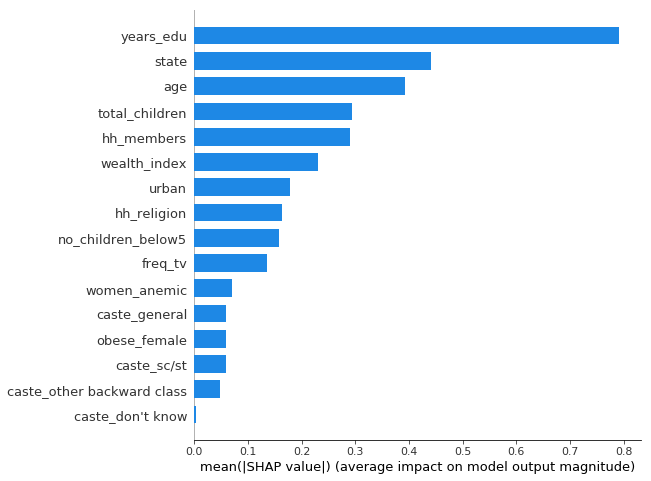

In [34]:
shap.summary_plot(shap_values, dataset, plot_type="bar")

The above figure shows the global mean(|Tree SHAP|) method applied to our model. 

**The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units).** “Hidden” means integrating the variable out of the model. Since the impact of hiding a feature changes depending on what other features are also hidden, Shapley values are used to enforce consistency and accuracy.

However, since we now have individualized explanations for every person in our dataset, to get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low):

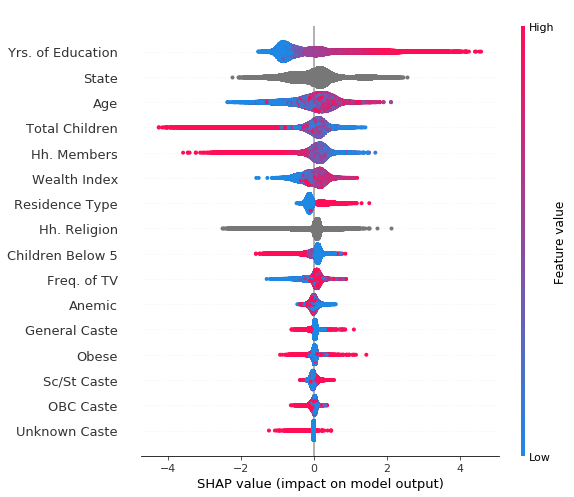

In [35]:
shap.summary_plot(shap_values, dataset_display)

- Every person has one dot on each row. 
- **The x position of the dot is the impact of that feature on the model’s prediction for the person.**
- **The color of the dot represents the value of that feature for the customer.** Categorical variables are colored grey.
- Dots that don’t fit on the row pile up to show density (since our dataset is large). 
- Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).

**How to use this**: We can make analysis similar to [the blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for interpretting our models.

---

### SHAP Dependence Plots

Next, to understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP dependence plots show the effect of a single feature across the whole dataset. **They plot a feature's value vs. the SHAP value of that feature across many samples.** 

SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. **One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.**

Good example of using Dependency Plots: https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

#### Plots for 'age'


Feature: age, Interaction Feature: age


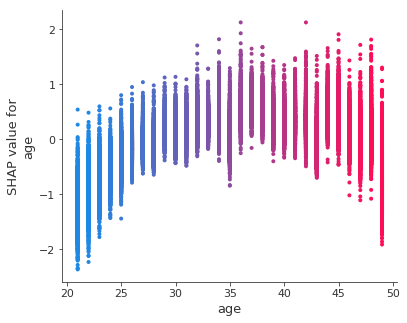


Feature: age, Interaction Feature: urban


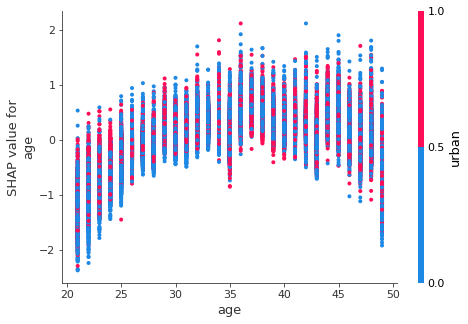


Feature: age, Interaction Feature: caste_sc/st


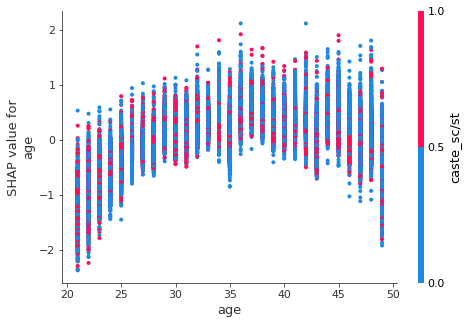


Feature: age, Interaction Feature: caste_general


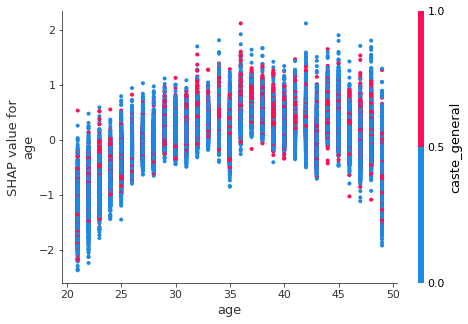


Feature: age, Interaction Feature: wealth_index


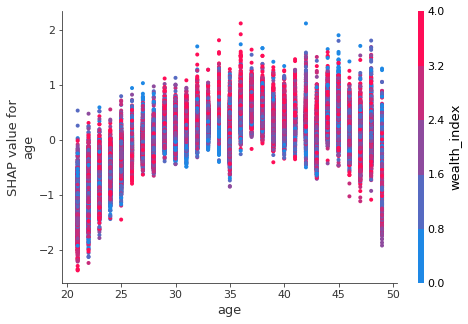


Feature: age, Interaction Feature: years_edu


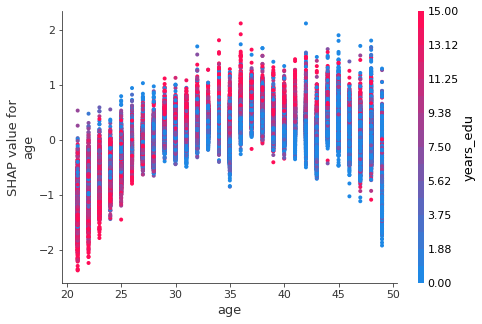


Feature: age, Interaction Feature: no_children_below5


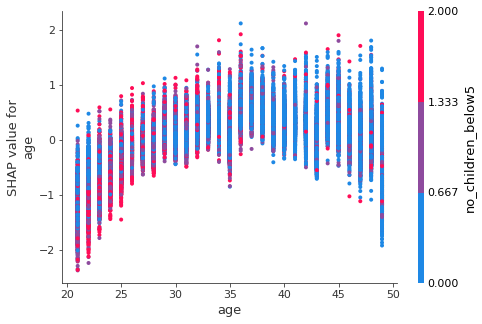


Feature: age, Interaction Feature: total_children


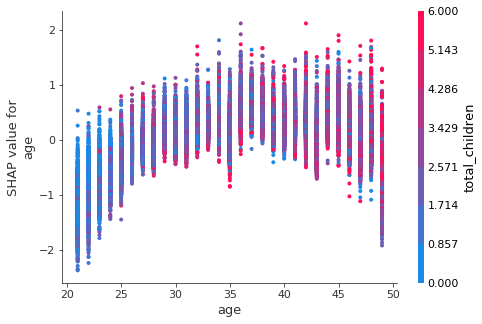


Feature: hh_religion, Interaction Feature: age


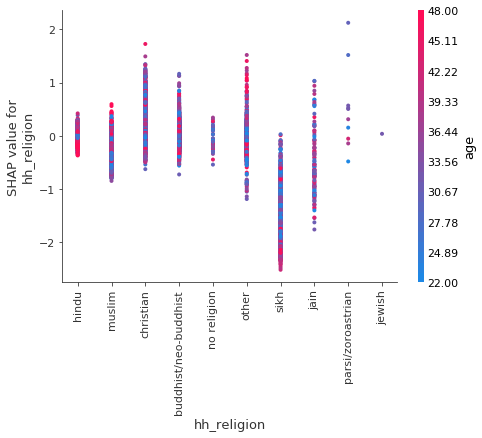


Feature: state, Interaction Feature: age


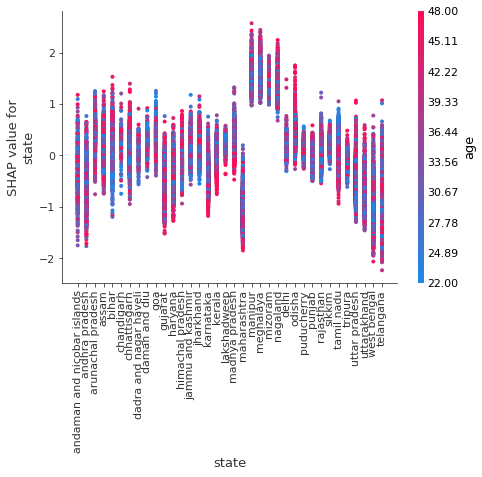

In [37]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children'),
         ('hh_religion', 'age'),
         ('state', 'age')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


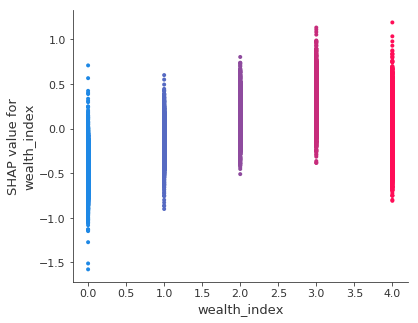


Feature: wealth_index, Interaction Feature: age


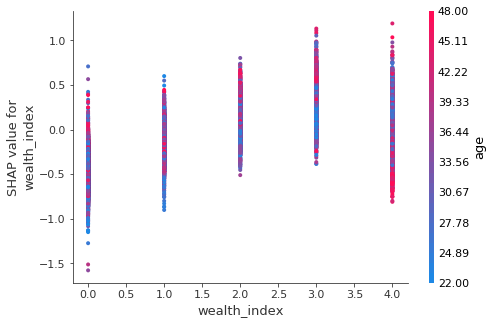


Feature: wealth_index, Interaction Feature: urban


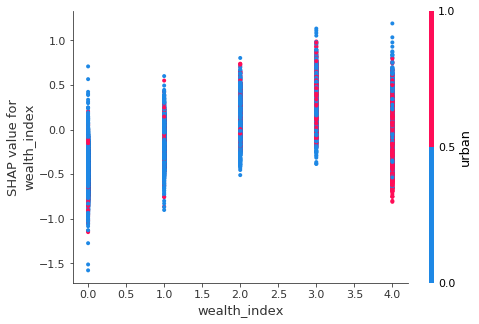


Feature: wealth_index, Interaction Feature: caste_sc/st


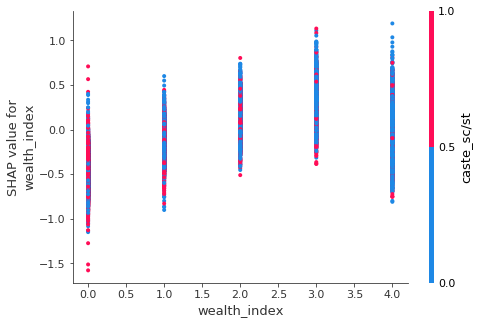


Feature: wealth_index, Interaction Feature: caste_general


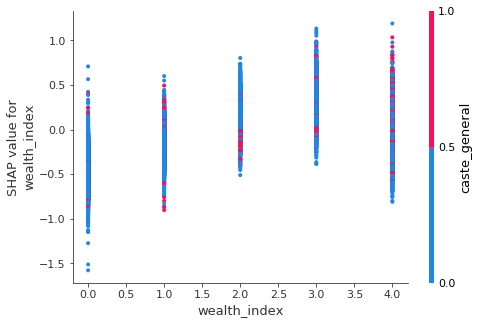


Feature: wealth_index, Interaction Feature: years_edu


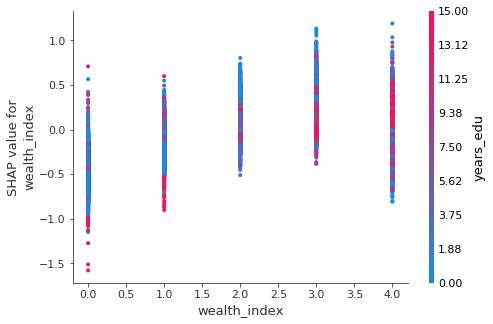


Feature: wealth_index, Interaction Feature: no_children_below5


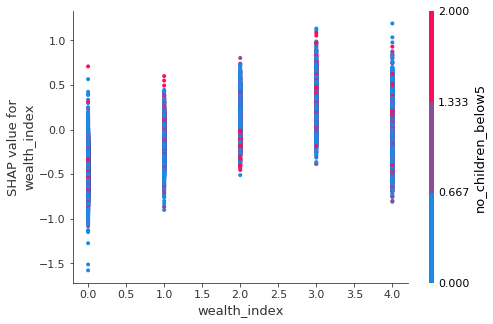


Feature: wealth_index, Interaction Feature: total_children


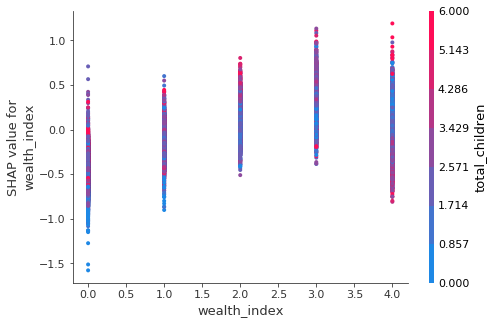


Feature: hh_religion, Interaction Feature: wealth_index


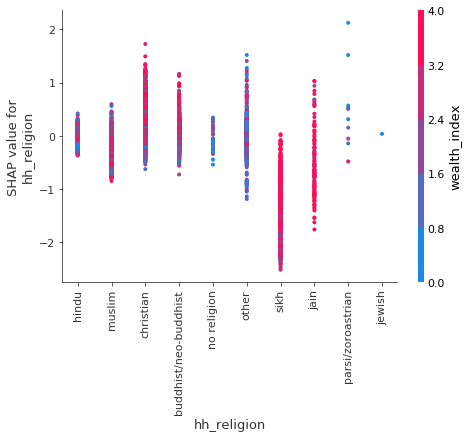


Feature: state, Interaction Feature: wealth_index


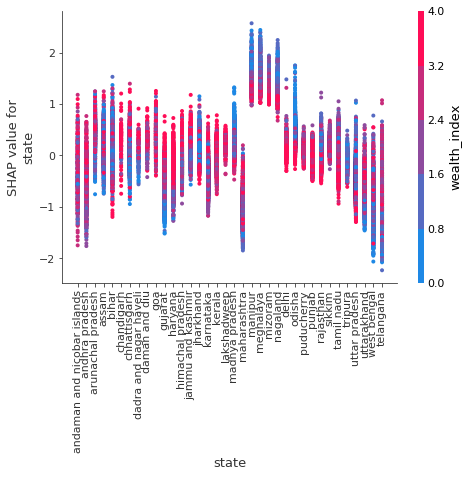

In [38]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children'),
         ('hh_religion', 'wealth_index'),
         ('state', 'wealth_index')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


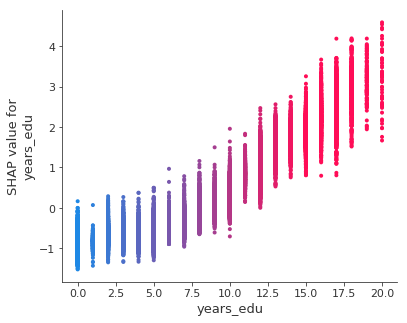


Feature: years_edu, Interaction Feature: age


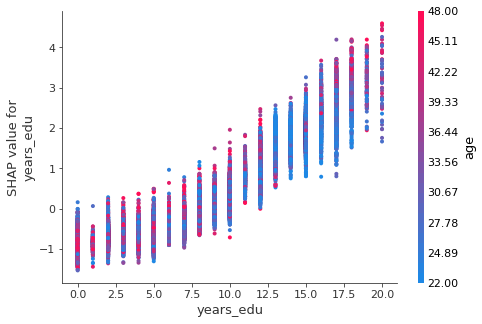


Feature: years_edu, Interaction Feature: urban


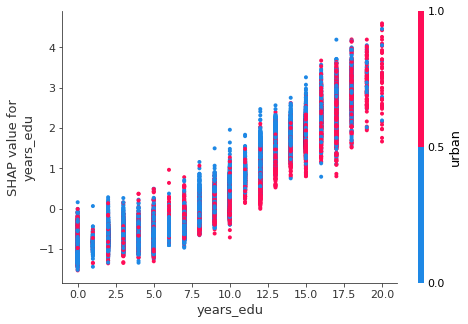


Feature: years_edu, Interaction Feature: caste_sc/st


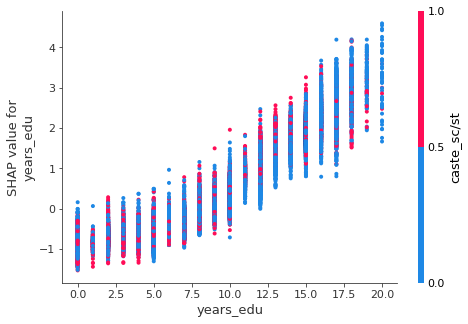


Feature: years_edu, Interaction Feature: caste_general


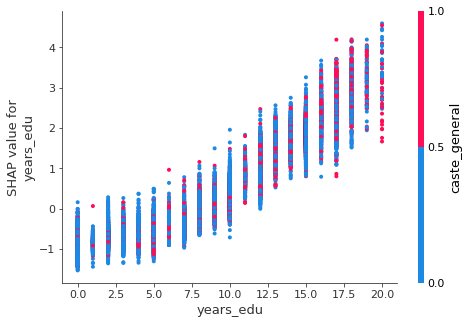


Feature: years_edu, Interaction Feature: wealth_index


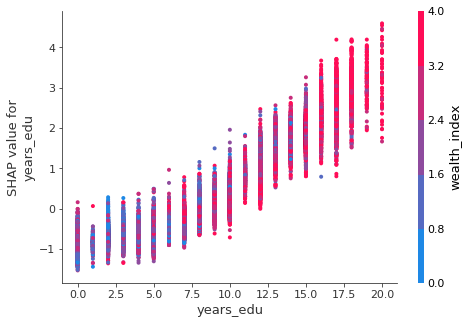


Feature: years_edu, Interaction Feature: no_children_below5


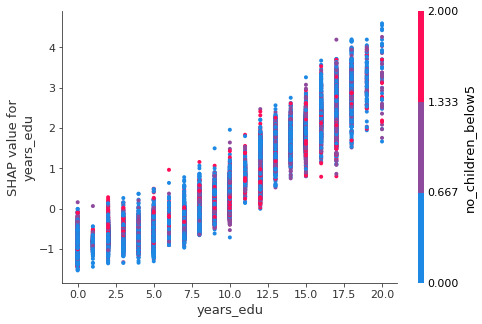


Feature: years_edu, Interaction Feature: total_children


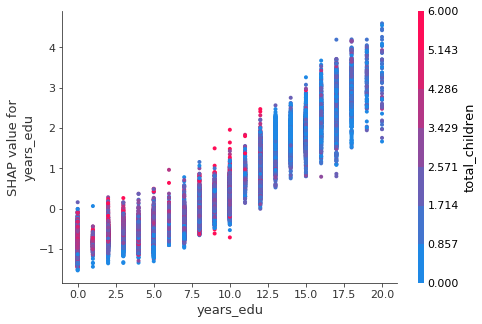


Feature: hh_religion, Interaction Feature: years_edu


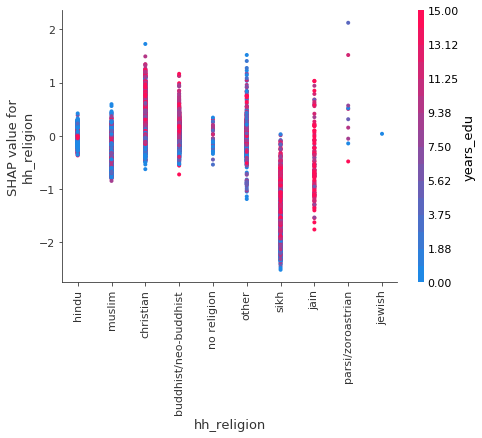


Feature: state, Interaction Feature: years_edu


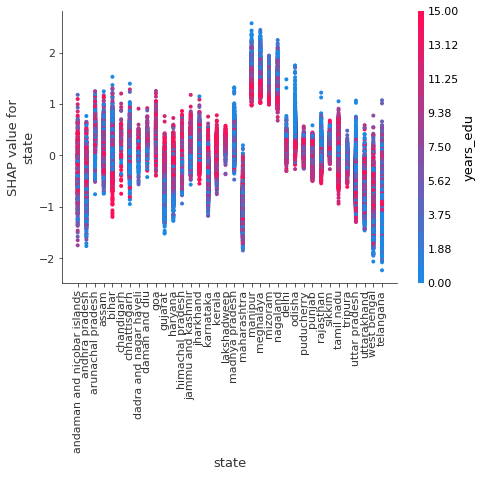

In [39]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children'),
         ('hh_religion', 'years_edu'),
         ('state', 'years_edu')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


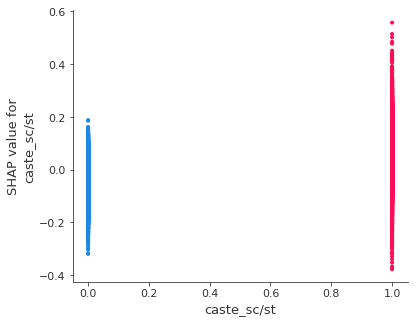


Feature: caste_sc/st, Interaction Feature: age


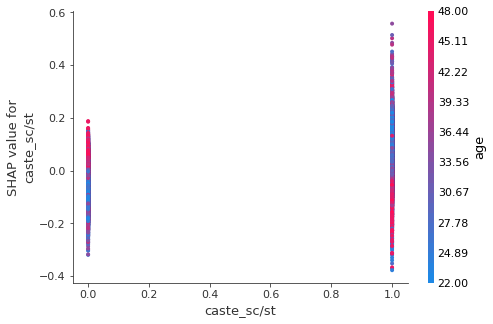


Feature: caste_sc/st, Interaction Feature: urban


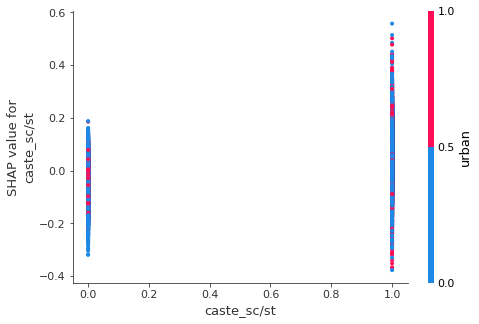


Feature: caste_sc/st, Interaction Feature: years_edu


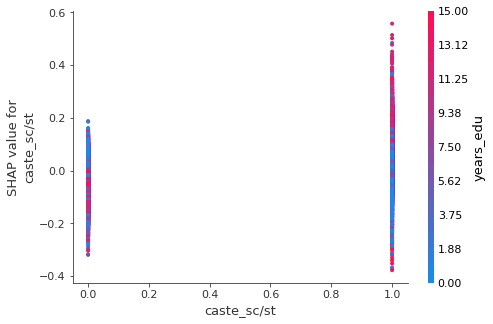


Feature: caste_sc/st, Interaction Feature: wealth_index


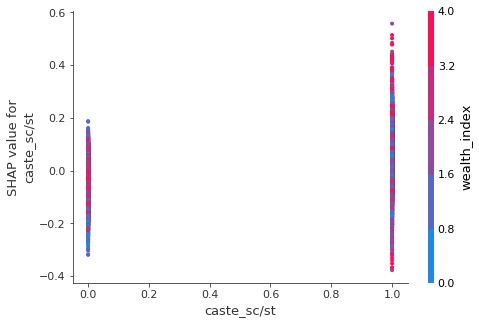


Feature: caste_sc/st, Interaction Feature: no_children_below5


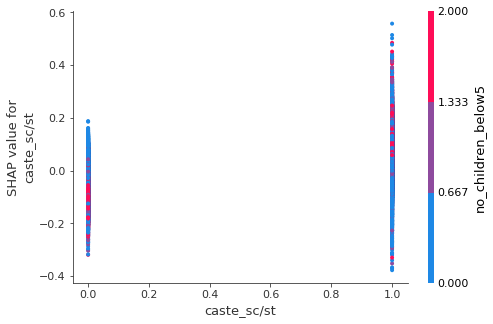


Feature: caste_sc/st, Interaction Feature: total_children


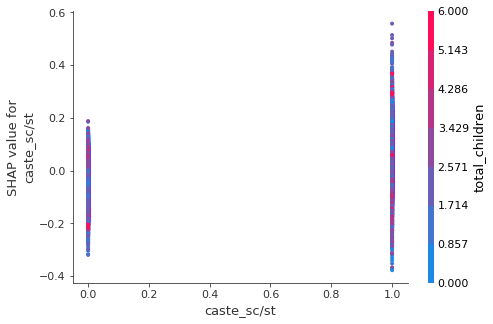


Feature: hh_religion, Interaction Feature: caste_sc/st


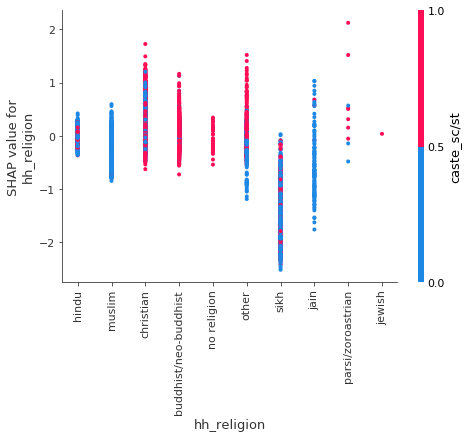


Feature: state, Interaction Feature: caste_sc/st


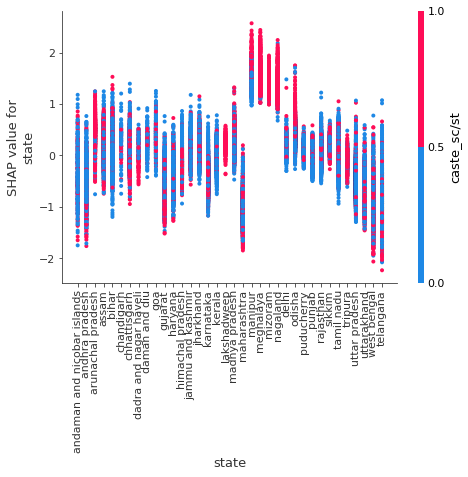

In [40]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children'),
         ('hh_religion', 'caste_sc/st'),
         ('state', 'caste_sc/st')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


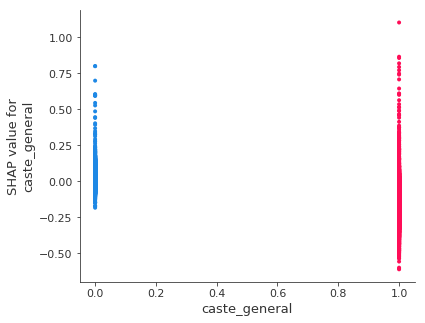


Feature: caste_general, Interaction Feature: age


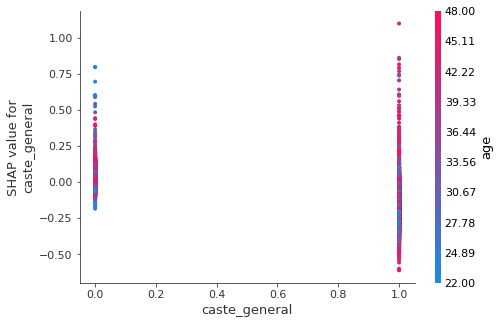


Feature: caste_general, Interaction Feature: urban


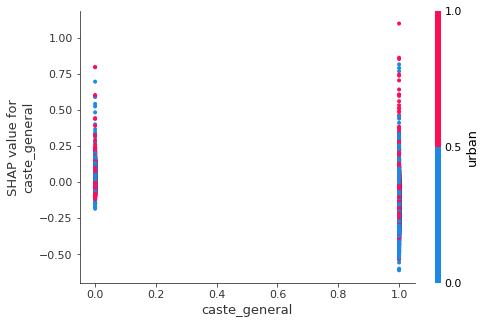


Feature: caste_general, Interaction Feature: years_edu


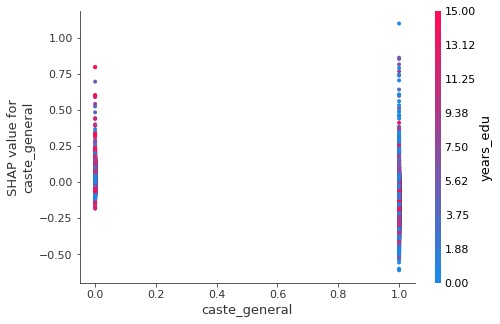


Feature: caste_general, Interaction Feature: wealth_index


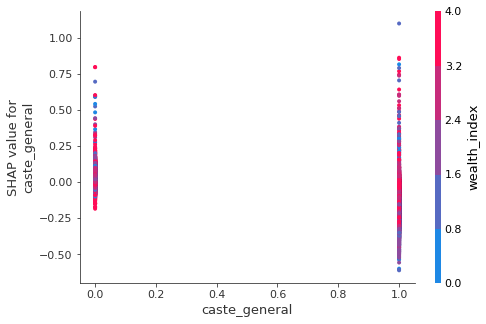


Feature: caste_general, Interaction Feature: no_children_below5


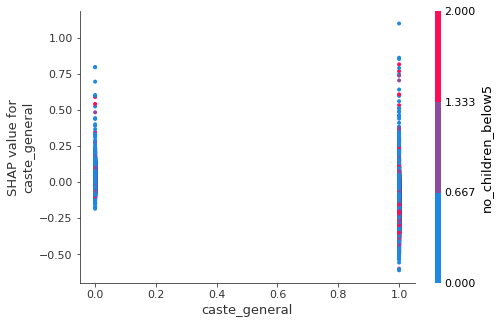


Feature: caste_general, Interaction Feature: total_children


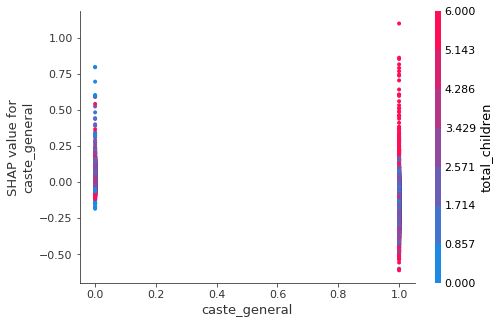


Feature: hh_religion, Interaction Feature: caste_general


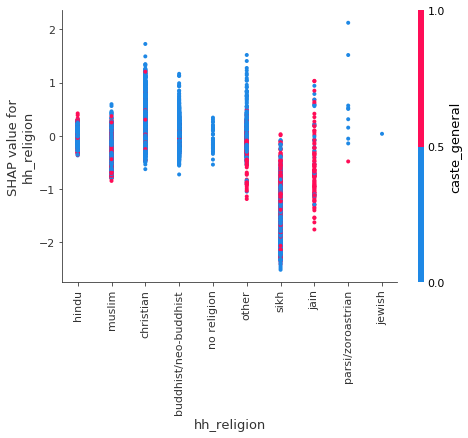


Feature: state, Interaction Feature: caste_general


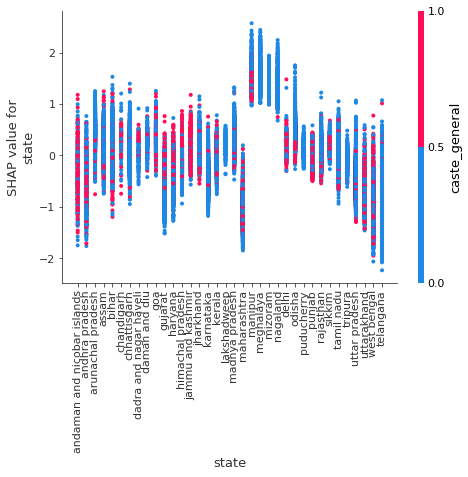

In [41]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
         ('hh_religion', 'caste_general'),
         ('state', 'caste_general')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

---

# Visualizing Bar/Summary plots split by age bins


Age Range: 21 - 25 years
Sample size: 14034

state - 0.4311934364755243
wealth_index - 0.2424483837932801
hh_religion - 0.13868080571189895
women_anemic - 0.08050209773835065
obese_female - 0.04936720758204492
urban - 0.2148206572802434
freq_tv - 0.16164200534101056
age - 0.6000123082106207
years_edu - 0.8582757309801283
hh_members - 0.3424109257309364
no_children_below5 - 0.22766418874682465
total_children - 0.24337616166895387
caste_don't know - 0.003703992506502956
caste_general - 0.04803600926800763
caste_other backward class - 0.05438717473508545
caste_sc/st - 0.0698214803978477


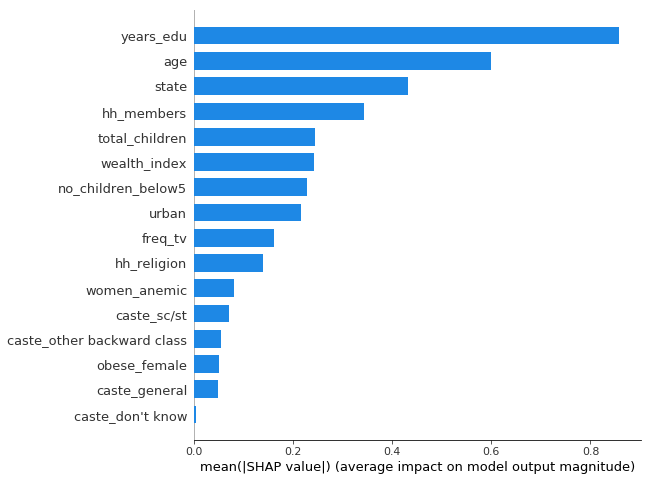

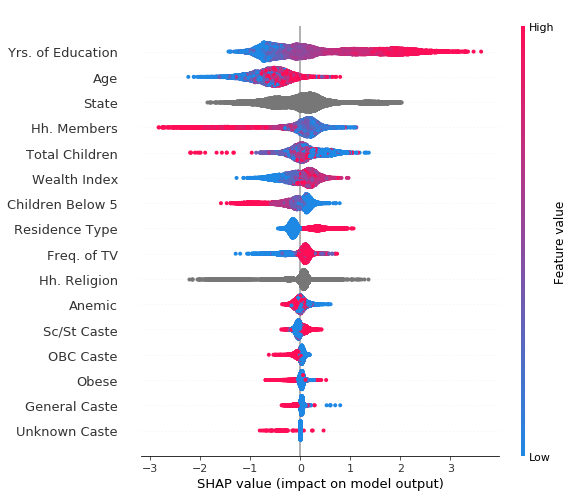


Age Range: 26 - 30 years
Sample size: 13706

state - 0.4201670229677057
wealth_index - 0.226149923003438
hh_religion - 0.16171370453338424
women_anemic - 0.06826909691797922
obese_female - 0.06821288996160167
urban - 0.18115518270672787
freq_tv - 0.1282616029624979
age - 0.17617979005723614
years_edu - 0.7987156344690098
hh_members - 0.29268866296869456
no_children_below5 - 0.1687240664435448
total_children - 0.19964121674582727
caste_don't know - 0.004696254182821685
caste_general - 0.05780455248446113
caste_other backward class - 0.04370163180586437
caste_sc/st - 0.056653155262532236


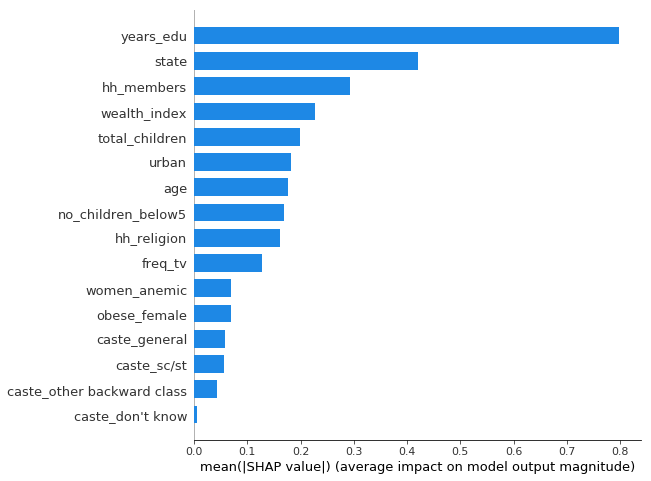

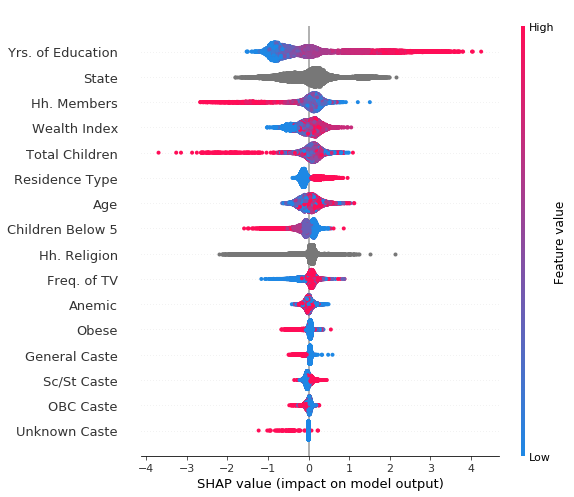


Age Range: 31 - 35 years
Sample size: 12526

state - 0.43514525039973895
wealth_index - 0.22323700971271102
hh_religion - 0.17871876650885135
women_anemic - 0.058287169886163726
obese_female - 0.06006366465696789
urban - 0.15540151324364546
freq_tv - 0.13077046732923375
age - 0.30367518394304205
years_edu - 0.768903033842897
hh_members - 0.2656193403222048
no_children_below5 - 0.14551777960285378
total_children - 0.24463444298126125
caste_don't know - 0.002561669572818768
caste_general - 0.05347679981245632
caste_other backward class - 0.0476053836095569
caste_sc/st - 0.07057875164932456


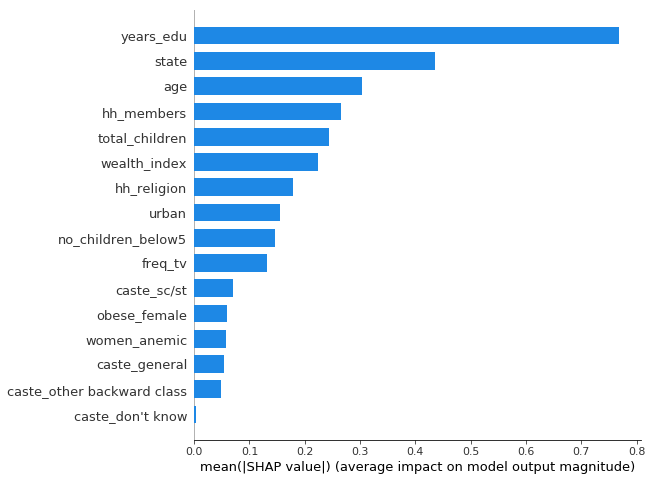

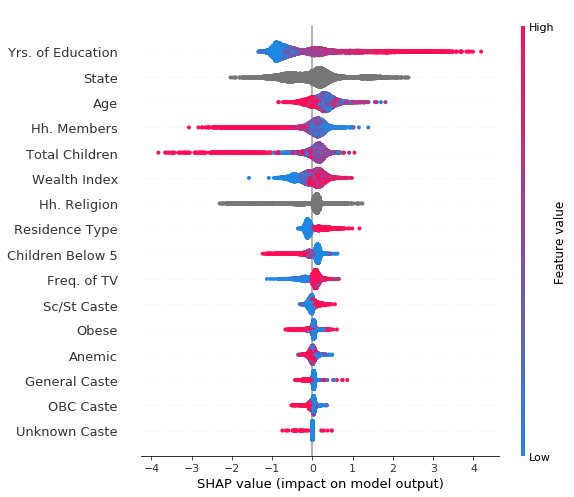


Age Range: 36 - 40 years
Sample size: 11283

state - 0.44729303526168246
wealth_index - 0.2473032008028458
hh_religion - 0.18018081446841142
women_anemic - 0.05908766300199154
obese_female - 0.05694012976059111
urban - 0.14936164872732102
freq_tv - 0.1319397168779665
age - 0.40761850368263564
years_edu - 0.7490575026842256
hh_members - 0.27600957218837296
no_children_below5 - 0.12536721355847222
total_children - 0.3170210742272066
caste_don't know - 0.002452497877200384
caste_general - 0.060783849356771794
caste_other backward class - 0.04115069326058206
caste_sc/st - 0.05518705274975287


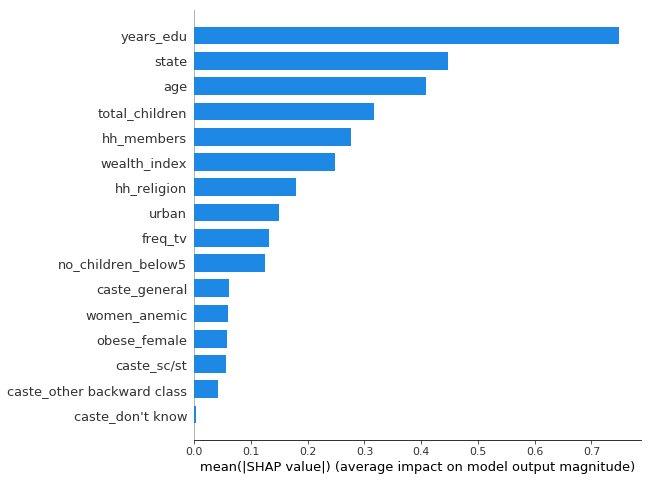

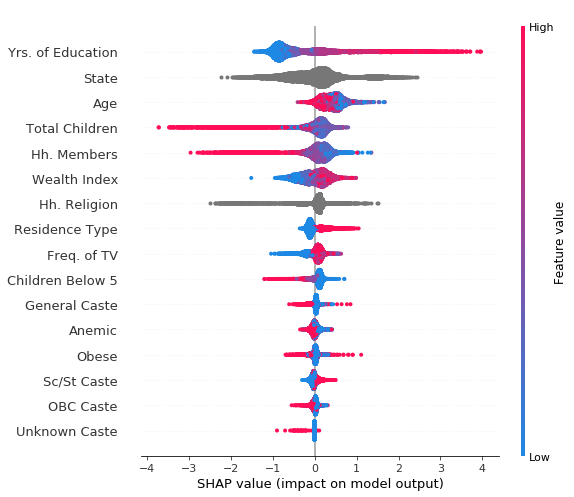


Age Range: 41 - 45 years
Sample size: 10087

state - 0.48383750039526835
wealth_index - 0.22270650587539165
hh_religion - 0.18167773166709394
women_anemic - 0.06908956225665765
obese_female - 0.055723050255578485
urban - 0.17539175521600367
freq_tv - 0.13094860219938798
age - 0.370248899263508
years_edu - 0.7322259787355042
hh_members - 0.2863277700508391
no_children_below5 - 0.10741897380360971
total_children - 0.4393305088255433
caste_don't know - 0.0020607356759359905
caste_general - 0.08105602664832298
caste_other backward class - 0.04648424053773165
caste_sc/st - 0.045575844139291936


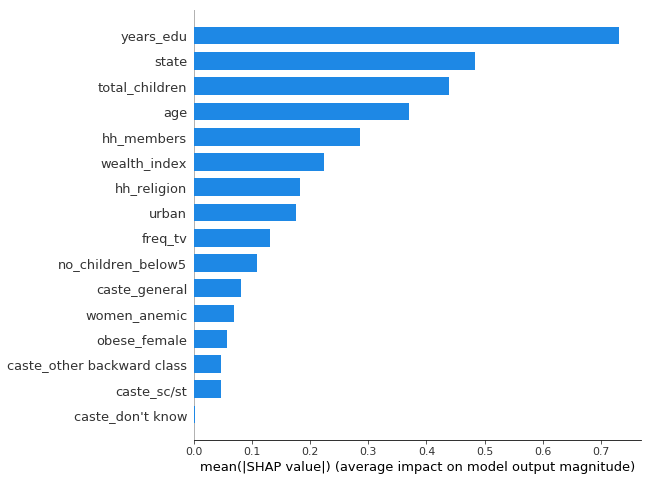

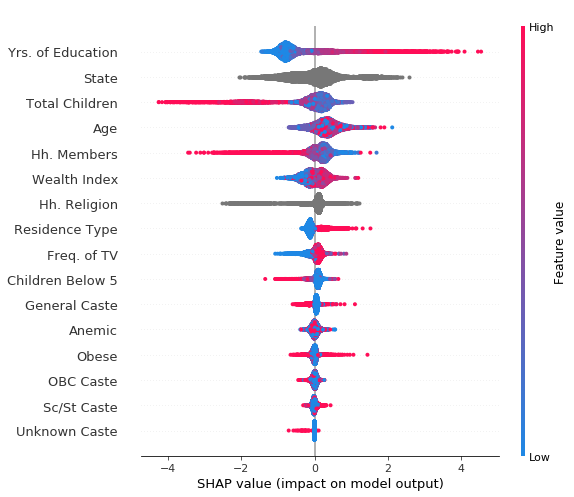


Age Range: 46 - 50 years
Sample size: 6013

state - 0.4459999274374072
wealth_index - 0.22822708360994942
hh_religion - 0.15022375214833839
women_anemic - 0.1072409971173746
obese_female - 0.05601420749059834
urban - 0.19524910574308038
freq_tv - 0.1356365629514302
age - 0.3953982249918827
years_edu - 0.765042541967817
hh_members - 0.2801059546518702
no_children_below5 - 0.11746852407920025
total_children - 0.4261548424971268
caste_don't know - 0.001853749782652308
caste_general - 0.07780684787878901
caste_other backward class - 0.06827881454282964
caste_sc/st - 0.04391783667958432


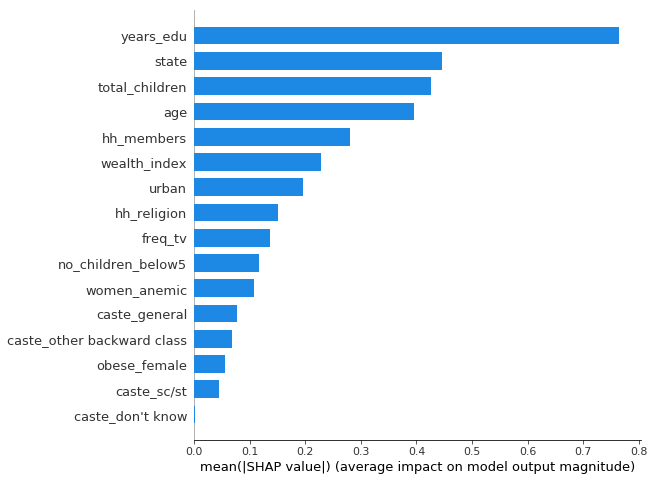

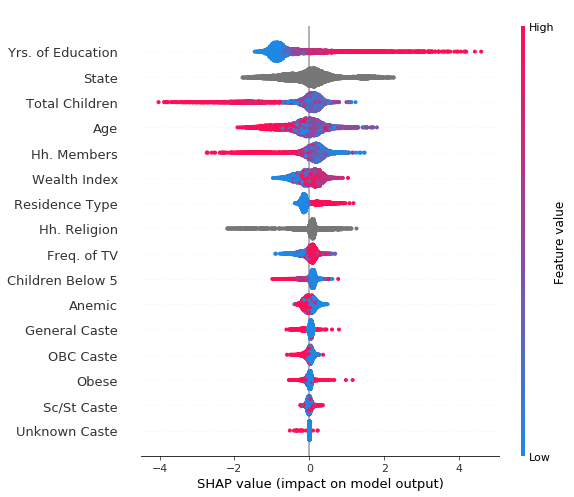

In [42]:
bins = [(21,25), (26,30), (31,35), (36,40), (41,45), (46,50)]

for low, high in bins:
    # Sample dataset by age range
    dataset_sample = dataset[(dataset.age > low) & (dataset.age <= high)]
    dataset_display_sample = dataset_display[(dataset.age > low) & (dataset.age <= high)]
    targets_sample = targets[(dataset.age > low) & (dataset.age <= high)]
    shap_values_sample = shap_values[(dataset.age > low) & (dataset.age <= high)]
    
    print("\nAge Range: {} - {} years".format(low, high))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

# Visualizing Bar/Summary plots split by State


State: andaman and nicobar islands
Sample size: 336

state - 0.5224408804668674
wealth_index - 0.18118797113563306
hh_religion - 0.2122533022898871
women_anemic - 0.14981412699452262
obese_female - 0.07251520575795073
urban - 0.18655746685866412
freq_tv - 0.15062153007863324
age - 0.3877107734865599
years_edu - 0.8621506976068173
hh_members - 0.30417939516272957
no_children_below5 - 0.13703859544881106
total_children - 0.1964365527993014
caste_don't know - 0.002030939127788306
caste_general - 0.09802288786976748
caste_other backward class - 0.034733207272538424
caste_sc/st - 0.059740523913565345


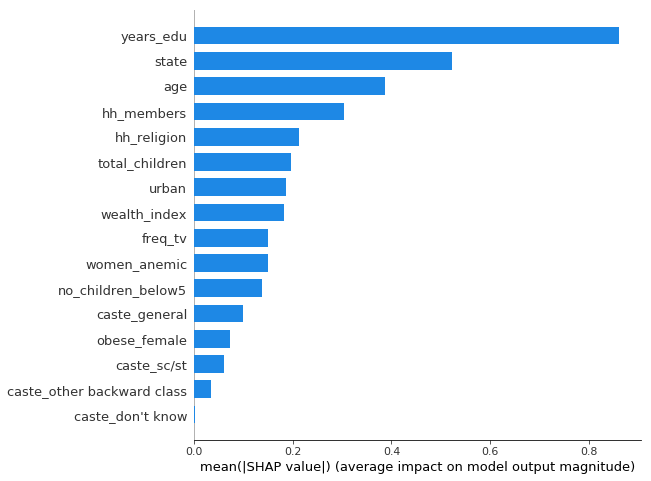

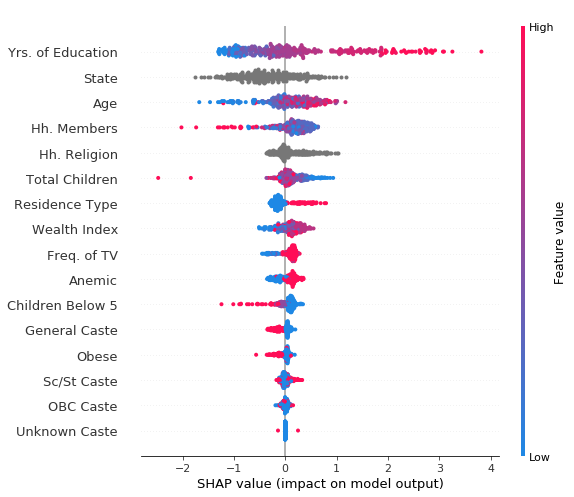


State: andhra pradesh
Sample size: 1239

state - 0.6014839566688588
wealth_index - 0.20870206669050675
hh_religion - 0.11470623536787677
women_anemic - 0.10500699556480533
obese_female - 0.08082849965516548
urban - 0.21230075872245355
freq_tv - 0.15691202869169413
age - 0.39317211647833455
years_edu - 0.8335041756017247
hh_members - 0.32353132962097153
no_children_below5 - 0.14807512869974745
total_children - 0.20677696850619134
caste_don't know - 0.002056226481144269
caste_general - 0.08137182438170892
caste_other backward class - 0.053423480030327784
caste_sc/st - 0.03813350536607569


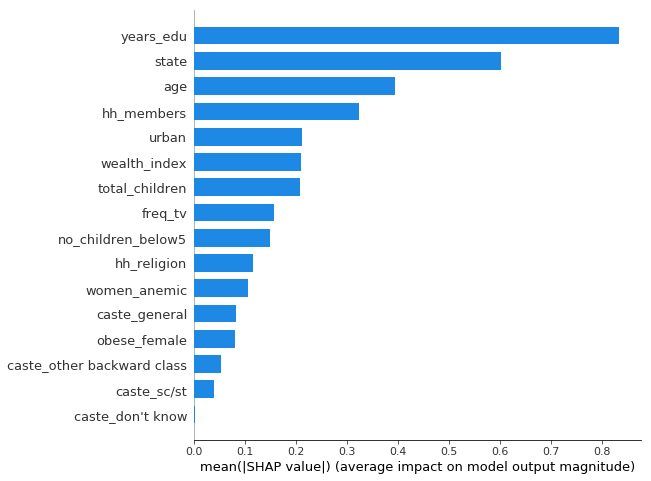

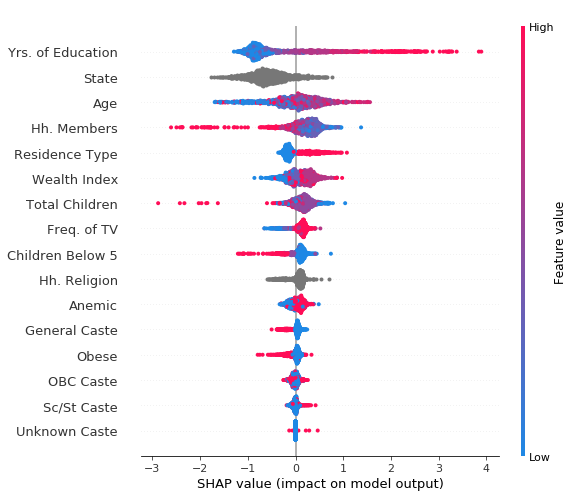


State: arunachal pradesh
Sample size: 1662

state - 0.4687205315613978
wealth_index - 0.2643024211799561
hh_religion - 0.1605731823781173
women_anemic - 0.15169384875483052
obese_female - 0.07267861351847117
urban - 0.18554141778446737
freq_tv - 0.08973564705114752
age - 0.34757834772507995
years_edu - 0.8216400748227789
hh_members - 0.22965081893605543
no_children_below5 - 0.09304422892080844
total_children - 0.2925936688950189
caste_don't know - 0.002711527954176463
caste_general - 0.06420833849820225
caste_other backward class - 0.04943238290150779
caste_sc/st - 0.10646783464585977


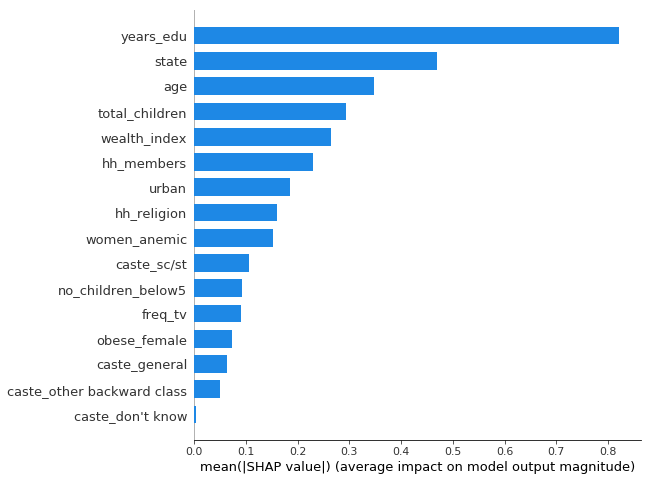

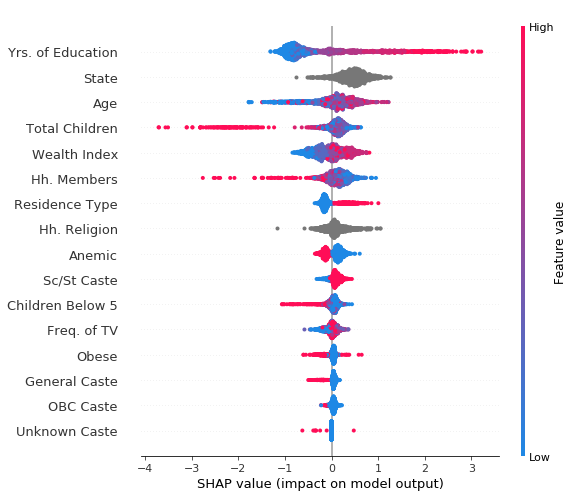


State: assam
Sample size: 2858

state - 0.2541002532133357
wealth_index - 0.24702505376520623
hh_religion - 0.09166210302088217
women_anemic - 0.07935502158728006
obese_female - 0.059243899966127674
urban - 0.1507441935173465
freq_tv - 0.11572197732638205
age - 0.38155207176650807
years_edu - 0.6564330252241047
hh_members - 0.25993138887338485
no_children_below5 - 0.13953282876484036
total_children - 0.2833163857889245
caste_don't know - 0.0023993011214361003
caste_general - 0.08111549630053677
caste_other backward class - 0.0609434944342594
caste_sc/st - 0.09710554486546491


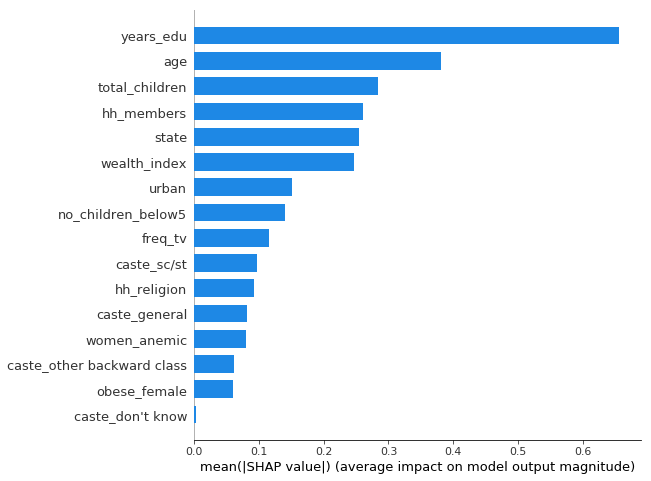

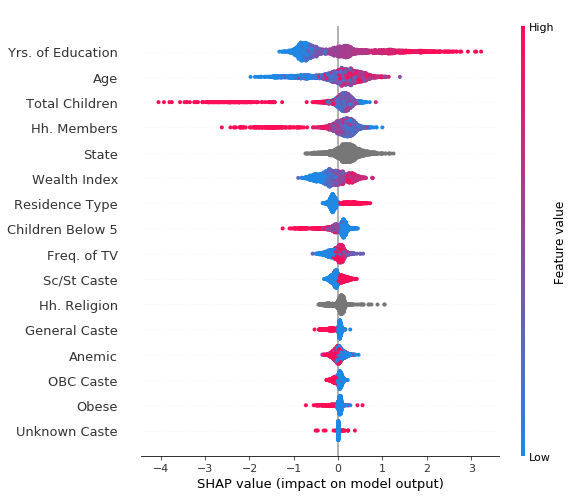


State: bihar
Sample size: 4860

state - 0.25108463838446804
wealth_index - 0.3117893186096343
hh_religion - 0.09504819649616324
women_anemic - 0.10556362653348453
obese_female - 0.060678065765971186
urban - 0.14572879200909153
freq_tv - 0.1817561239452889
age - 0.4359127697637039
years_edu - 0.7361975742202778
hh_members - 0.35763925757243503
no_children_below5 - 0.21912651183849444
total_children - 0.4371932903236975
caste_don't know - 0.0012287442508829797
caste_general - 0.06350010809813274
caste_other backward class - 0.06785460985217448
caste_sc/st - 0.0740219890846178


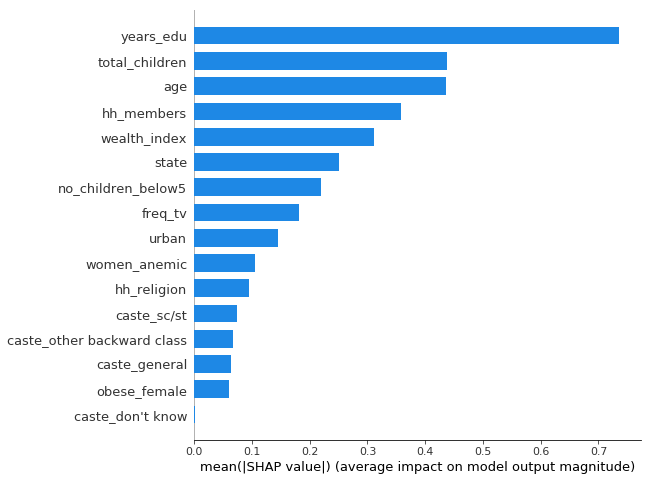

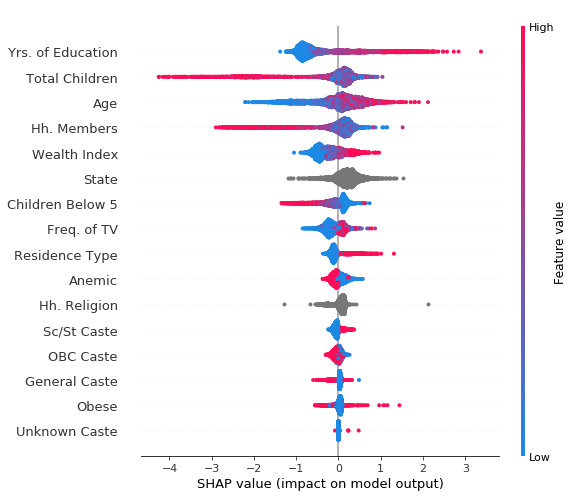


State: chandigarh
Sample size: 87

state - 0.37371348518565994
wealth_index - 0.2290805327665975
hh_religion - 0.2045412934288302
women_anemic - 0.04380184303576607
obese_female - 0.09262768577677676
urban - 0.20927466280806262
freq_tv - 0.14526261899180948
age - 0.44853220426589974
years_edu - 0.9205434943647882
hh_members - 0.23355392829297553
no_children_below5 - 0.13628435203158146
total_children - 0.22325520894275946
caste_don't know - 0.0010395826768197522
caste_general - 0.06254958266770577
caste_other backward class - 0.05349711458010891
caste_sc/st - 0.043766369087462086


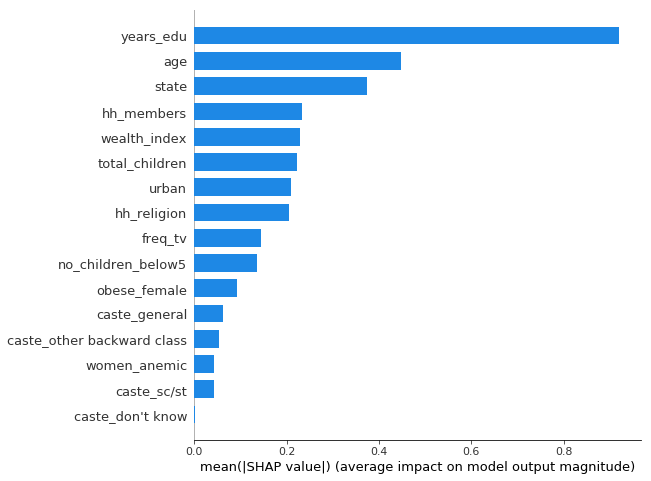

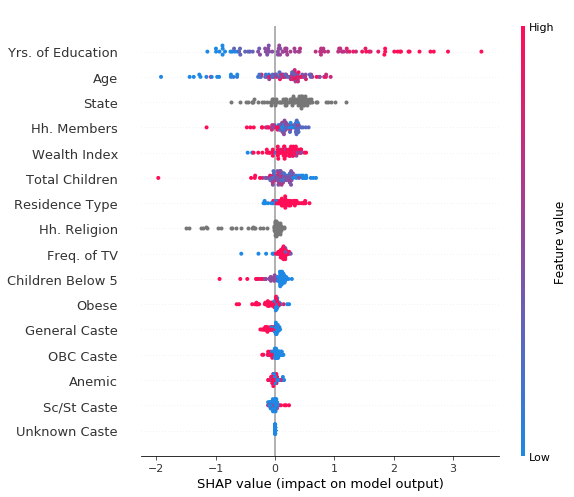


State: chhattisgarh
Sample size: 2836

state - 0.22629229072220772
wealth_index - 0.3089676482230333
hh_religion - 0.0827130707058401
women_anemic - 0.07221746030865044
obese_female - 0.04911100813312378
urban - 0.15956492800704092
freq_tv - 0.18113177356421106
age - 0.4120163627664243
years_edu - 0.7282820728883681
hh_members - 0.3129690241843665
no_children_below5 - 0.19337279761854695
total_children - 0.2738911340806012
caste_don't know - 0.0009884688441092735
caste_general - 0.039234264644890555
caste_other backward class - 0.059706684891494145
caste_sc/st - 0.05523364252113784


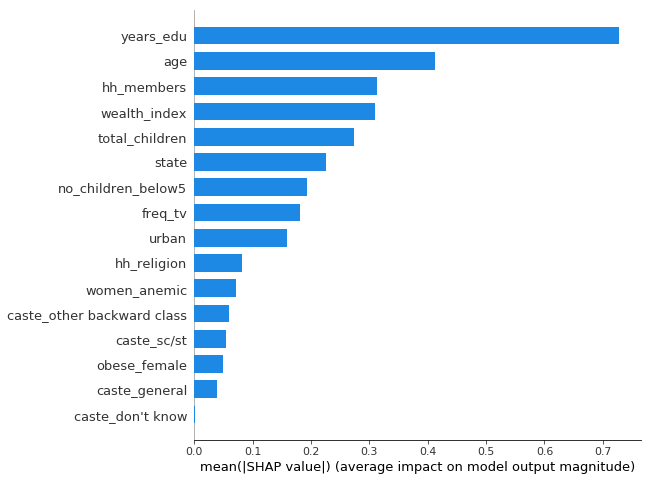

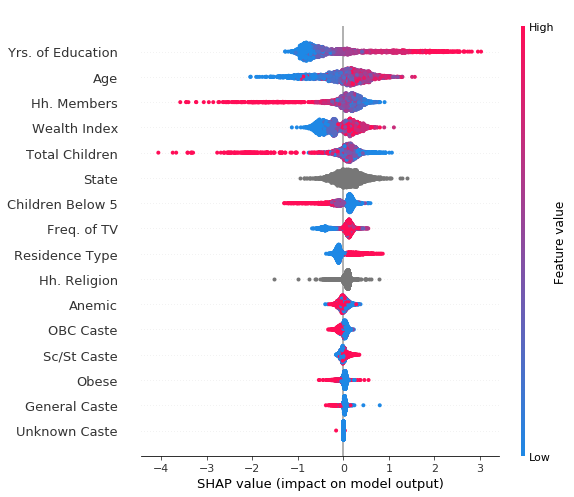


State: dadra and nagar haveli
Sample size: 118

state - 0.23598489090385374
wealth_index - 0.286941661279775
hh_religion - 0.0846750818479368
women_anemic - 0.07360937051728005
obese_female - 0.06249334428173964
urban - 0.1810865180001845
freq_tv - 0.20173570602228752
age - 0.37319904285279587
years_edu - 0.8025185850733124
hh_members - 0.286373425111202
no_children_below5 - 0.19648154710470733
total_children - 0.19475611391142975
caste_don't know - 0.005014507332954341
caste_general - 0.04502246804461701
caste_other backward class - 0.04699939951401103
caste_sc/st - 0.046725873151944444


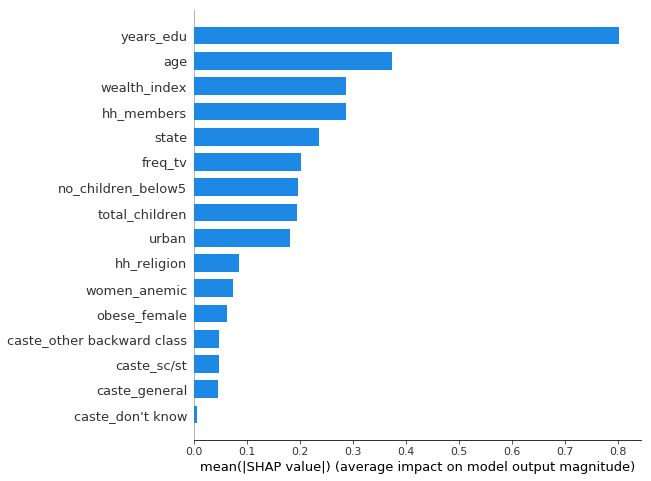

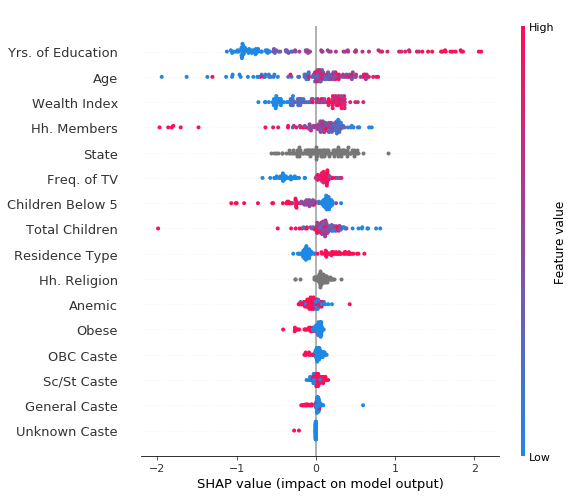


State: daman and diu
Sample size: 252

state - 0.2979891839022129
wealth_index - 0.2315277265551198
hh_religion - 0.08172208968365893
women_anemic - 0.05083260067579587
obese_female - 0.06647594947523369
urban - 0.19593757640885584
freq_tv - 0.14552077446573444
age - 0.36365224070004376
years_edu - 0.645221527078858
hh_members - 0.3024743176617865
no_children_below5 - 0.19581356633015173
total_children - 0.23943346688160427
caste_don't know - 0.015289483465918513
caste_general - 0.034625260648414063
caste_other backward class - 0.058396799539574155
caste_sc/st - 0.03745189238366826


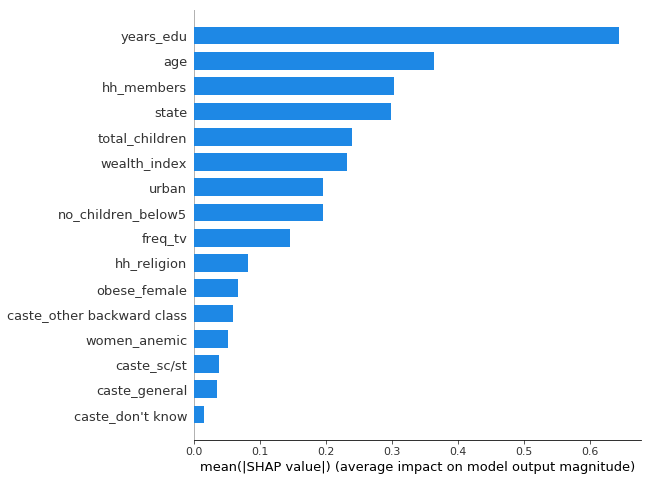

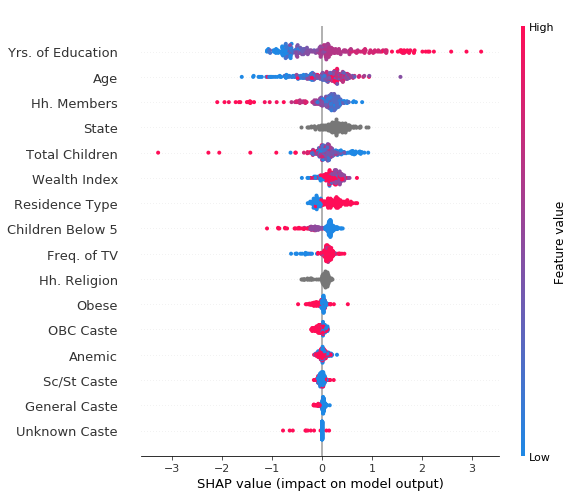


State: goa
Sample size: 567

state - 0.3836575151490094
wealth_index - 0.186407618061014
hh_religion - 0.10155245858180766
women_anemic - 0.05351183830277614
obese_female - 0.10234897935593963
urban - 0.17064411112418357
freq_tv - 0.13471653420241866
age - 0.33404465593275967
years_edu - 0.8258775588109294
hh_members - 0.25466873434254794
no_children_below5 - 0.1795000912022314
total_children - 0.2307393839554238
caste_don't know - 0.0008744626392211867
caste_general - 0.08004767593504743
caste_other backward class - 0.0516140487293355
caste_sc/st - 0.0401250593498174


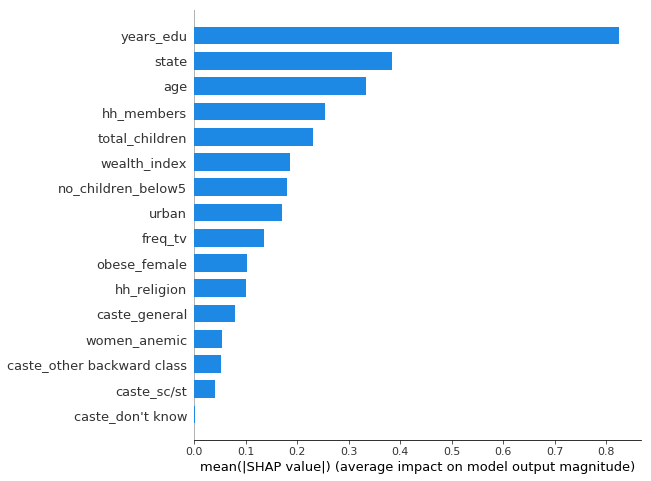

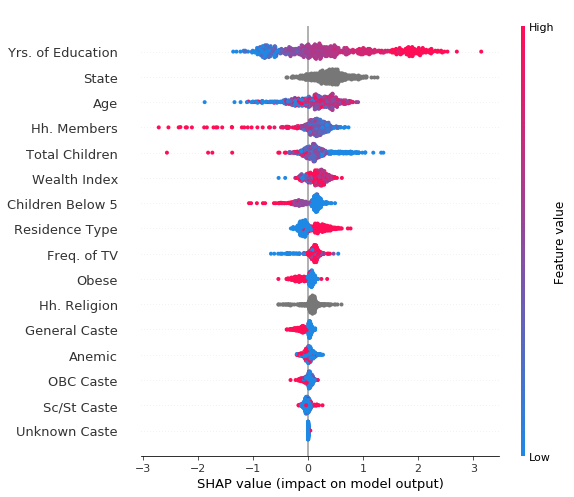


State: gujarat
Sample size: 4197

state - 0.5550198473042646
wealth_index - 0.24636799980190205
hh_religion - 0.08199544549209445
women_anemic - 0.07528598473327679
obese_female - 0.045741766662923636
urban - 0.24579809647913284
freq_tv - 0.13684050592722038
age - 0.3678110099778035
years_edu - 0.8023004149738323
hh_members - 0.292047916442535
no_children_below5 - 0.1495273076948643
total_children - 0.25110695353241136
caste_don't know - 0.005570348106324001
caste_general - 0.05187196036896561
caste_other backward class - 0.057452405917910676
caste_sc/st - 0.05718148337204179


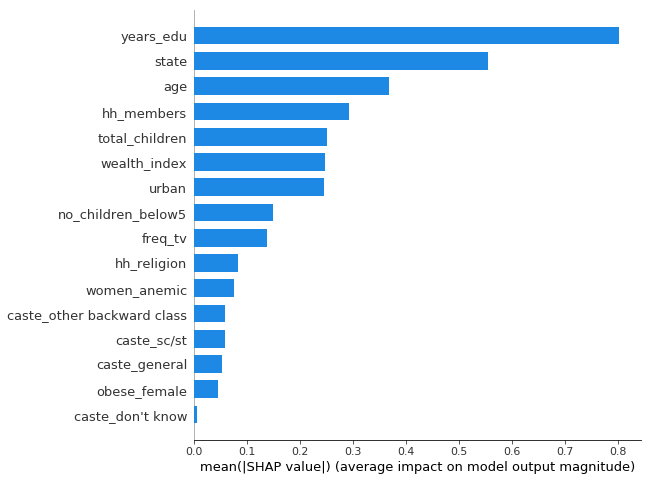

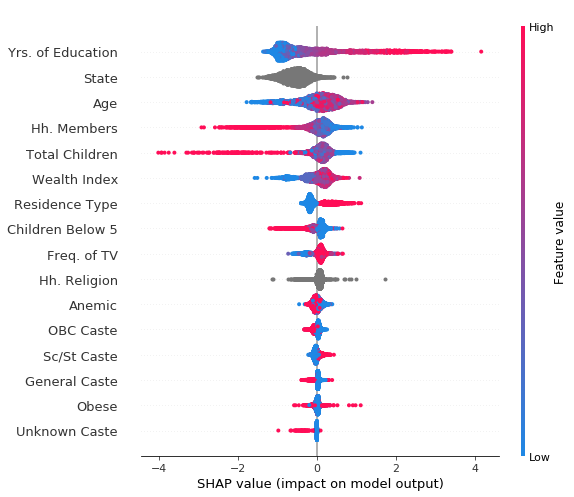


State: haryana
Sample size: 2415

state - 0.4220660106074437
wealth_index - 0.2036069123255031
hh_religion - 0.10670524705282075
women_anemic - 0.05336034723226517
obese_female - 0.05116191376363825
urban - 0.22161457405959925
freq_tv - 0.12285563541708254
age - 0.44202576308327024
years_edu - 0.9257547605743648
hh_members - 0.24736913680573497
no_children_below5 - 0.14277237342296284
total_children - 0.26267126202048113
caste_don't know - 0.0016995245192409428
caste_general - 0.038199444517623346
caste_other backward class - 0.058029310932457376
caste_sc/st - 0.04687732647246406


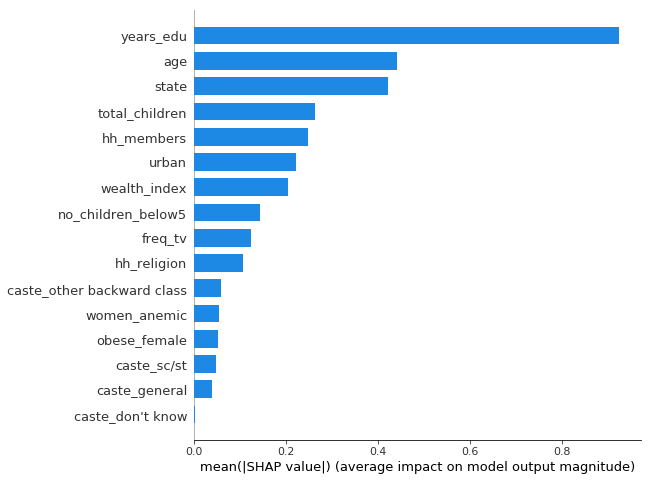

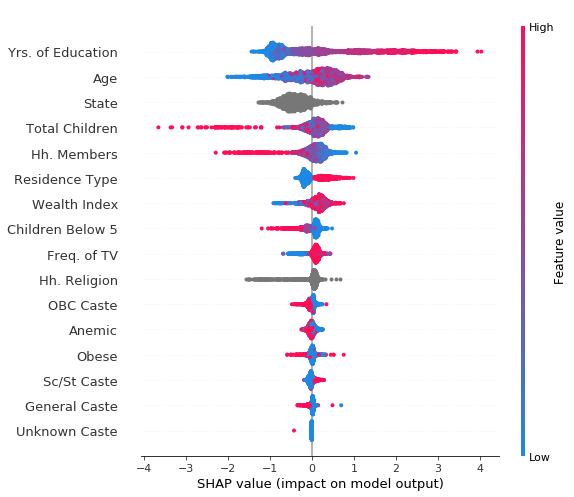


State: himachal pradesh
Sample size: 2193

state - 0.22634867404146944
wealth_index - 0.18218847502208751
hh_religion - 0.0715227267547322
women_anemic - 0.05074397545615156
obese_female - 0.05380243788373379
urban - 0.13574322557430388
freq_tv - 0.09938714523398243
age - 0.4745655101451901
years_edu - 0.9726521443615008
hh_members - 0.2624190288797111
no_children_below5 - 0.13834628979113825
total_children - 0.21392840531900778
caste_don't know - 0.002707343046868302
caste_general - 0.06337978671729916
caste_other backward class - 0.04473847034884644
caste_sc/st - 0.05410230898946138


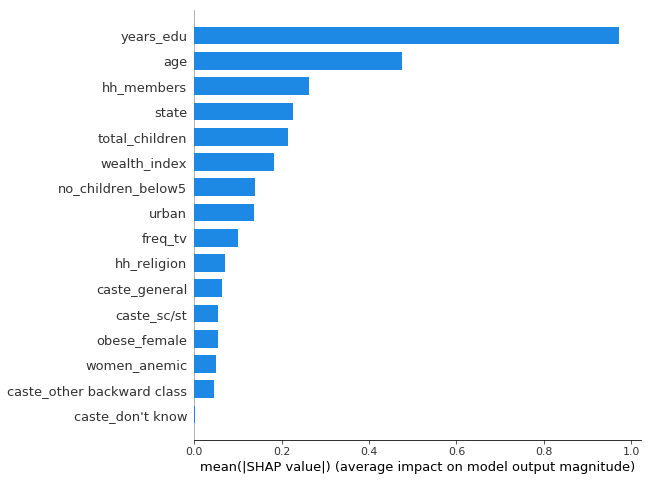

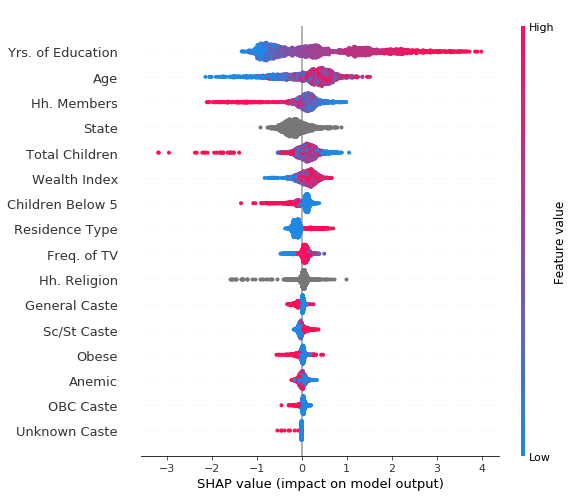


State: jammu and kashmir
Sample size: 2889

state - 0.16905080180043988
wealth_index - 0.23524244743059367
hh_religion - 0.19271611616546516
women_anemic - 0.0543609002770326
obese_female - 0.0716394408478791
urban - 0.15497319027169973
freq_tv - 0.1344954699258369
age - 0.41084159369885626
years_edu - 0.8976045766499016
hh_members - 0.26411040805585745
no_children_below5 - 0.12350112338712338
total_children - 0.2739381598276912
caste_don't know - 0.003964548393632339
caste_general - 0.07687554298507536
caste_other backward class - 0.046075571293663714
caste_sc/st - 0.05638850089897664


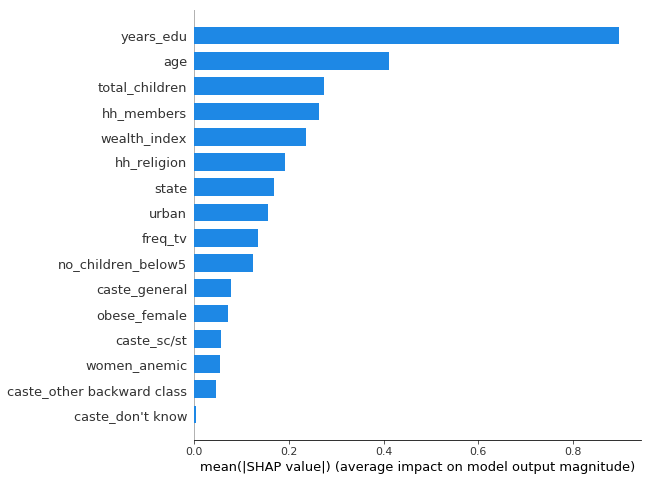

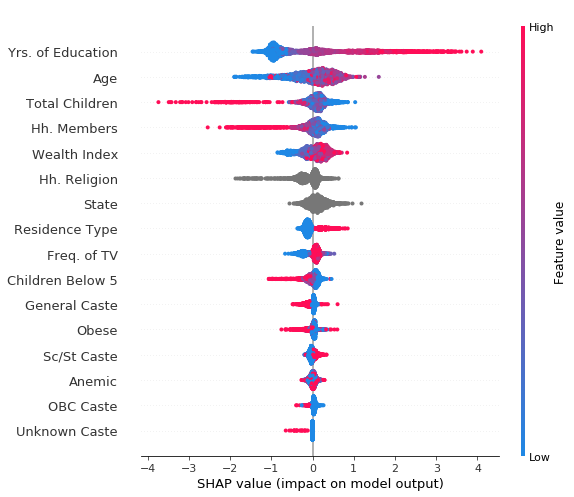


State: jharkhand
Sample size: 3171

state - 0.18143514409099976
wealth_index - 0.3004059192324797
hh_religion - 0.1245609148998876
women_anemic - 0.06192775733282604
obese_female - 0.044847446556998155
urban - 0.18044163701774948
freq_tv - 0.15950819254693224
age - 0.4132521407244786
years_edu - 0.7730069820603431
hh_members - 0.25269125447588264
no_children_below5 - 0.15879021477564645
total_children - 0.3266953799270156
caste_don't know - 0.0028548187458606327
caste_general - 0.049984718365517954
caste_other backward class - 0.043999314220093094
caste_sc/st - 0.05940046416609524


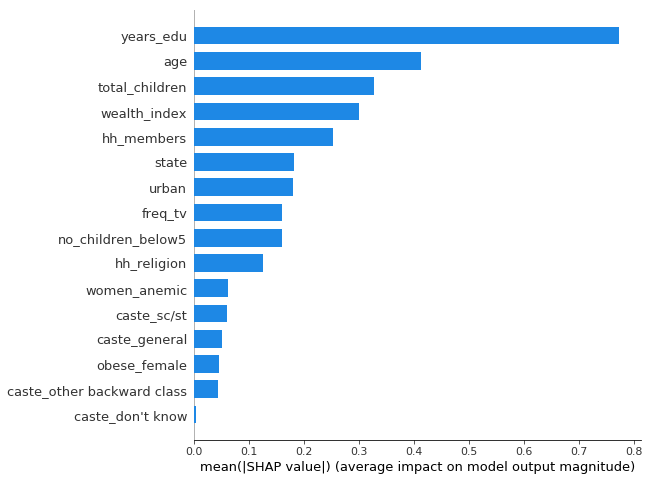

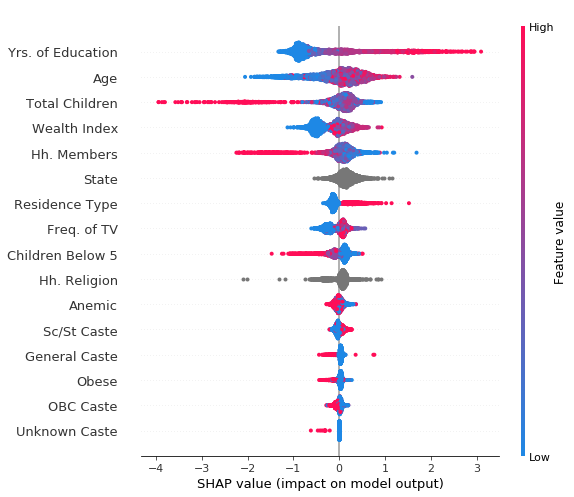


State: karnataka
Sample size: 2920

state - 0.4589346460630518
wealth_index - 0.16897390435792017
hh_religion - 0.11469662157097144
women_anemic - 0.06184286840977095
obese_female - 0.06822994318852783
urban - 0.22912241472948155
freq_tv - 0.15765692075376284
age - 0.41493194612757467
years_edu - 0.7645807823587787
hh_members - 0.2825643276070638
no_children_below5 - 0.15504635819224147
total_children - 0.22313441122437006
caste_don't know - 0.006712385272917434
caste_general - 0.04367774070223946
caste_other backward class - 0.042115993629950686
caste_sc/st - 0.0515008261477965


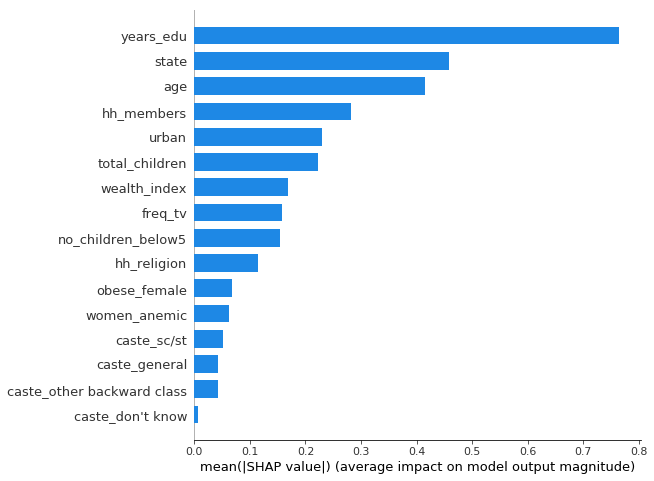

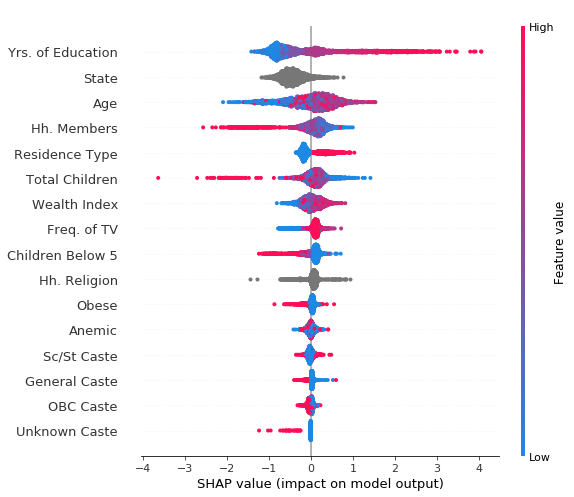


State: kerala
Sample size: 1761

state - 0.17913243659689657
wealth_index - 0.17503424670457451
hh_religion - 0.1824264872415019
women_anemic - 0.05358350312451684
obese_female - 0.054572825130927254
urban - 0.18418838883209973
freq_tv - 0.11297224401804484
age - 0.43157101524817343
years_edu - 1.0364110226474075
hh_members - 0.23398734925169176
no_children_below5 - 0.132163593290224
total_children - 0.22222868326604236
caste_don't know - 0.008248562081354922
caste_general - 0.05982143822270713
caste_other backward class - 0.047786050306803995
caste_sc/st - 0.0499138393646009


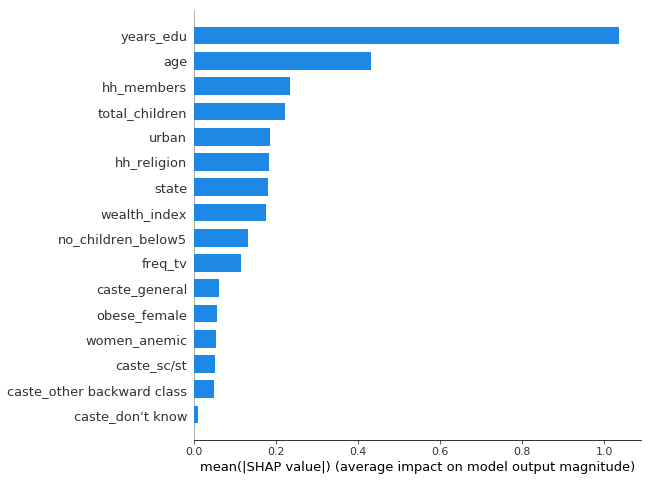

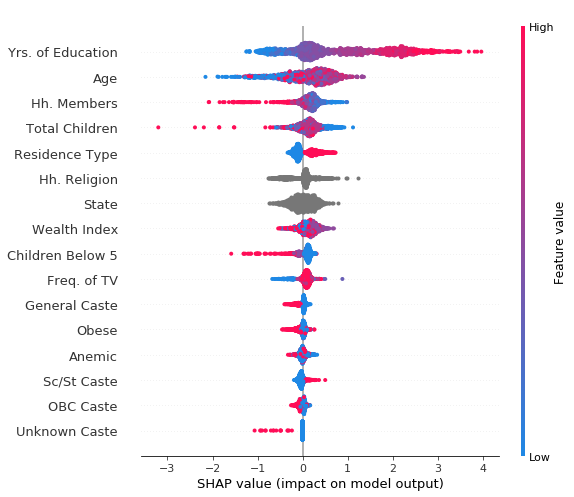


State: lakshadweep
Sample size: 165

state - 0.2353038504559328
wealth_index - 0.1459829279013682
hh_religion - 0.3249932267030693
women_anemic - 0.05180668476554779
obese_female - 0.07952182641477576
urban - 0.19804278263600608
freq_tv - 0.09554820191075734
age - 0.3751969991569382
years_edu - 0.915940138422609
hh_members - 0.29049325749752936
no_children_below5 - 0.1158594349327653
total_children - 0.2833494705122815
caste_don't know - 0.002424630926576947
caste_general - 0.02918631694741344
caste_other backward class - 0.04383296105023886
caste_sc/st - 0.0916007353286295


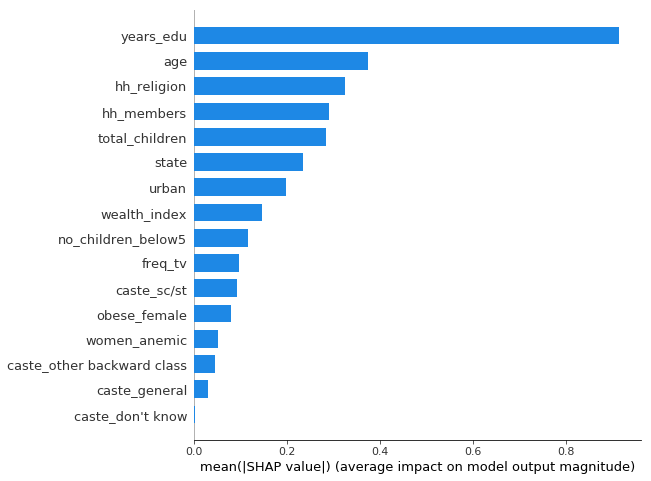

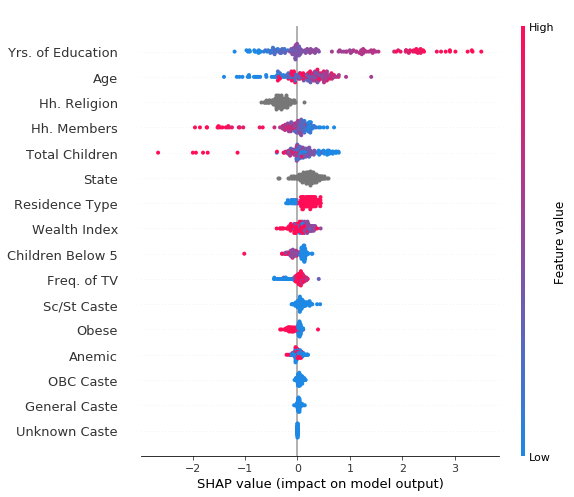


State: madhya pradesh
Sample size: 6829

state - 0.2927121479671057
wealth_index - 0.20427125993777273
hh_religion - 0.11037600600678238
women_anemic - 0.06256955169322868
obese_female - 0.045205566921695584
urban - 0.1866200205016917
freq_tv - 0.11751230196998165
age - 0.39637213846568486
years_edu - 0.7629892580443687
hh_members - 0.3249419782629358
no_children_below5 - 0.16369476127510477
total_children - 0.3246562851931388
caste_don't know - 0.0024820495927182435
caste_general - 0.046571687033295915
caste_other backward class - 0.05063968070599533
caste_sc/st - 0.06505275551415599


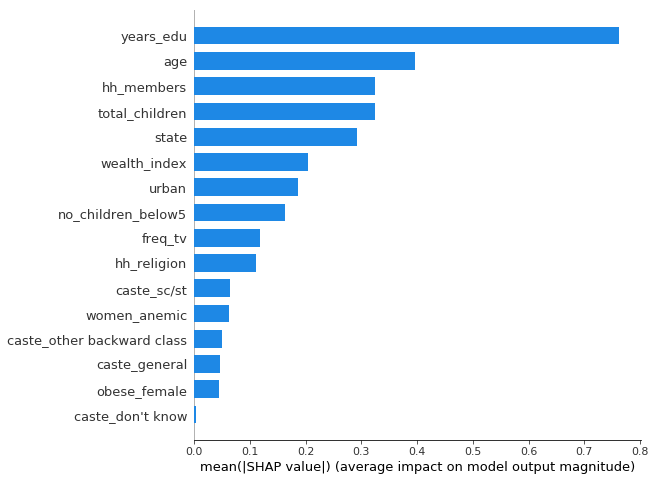

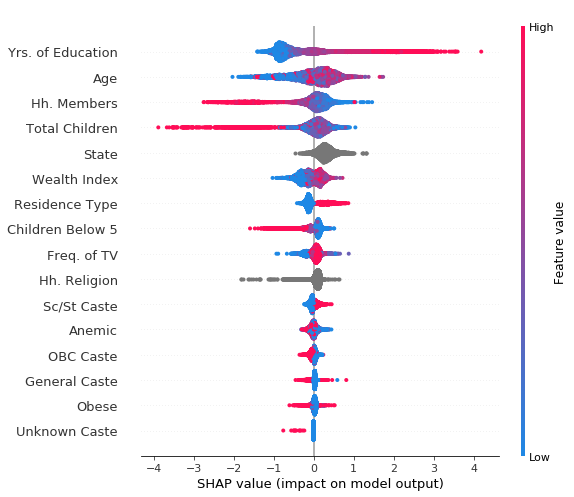


State: maharashtra
Sample size: 3368

state - 1.034091846749279
wealth_index - 0.23074719263705323
hh_religion - 0.1356607272475622
women_anemic - 0.05466718731726927
obese_female - 0.047522088184067224
urban - 0.276049418806763
freq_tv - 0.22148845334643505
age - 0.36956426017930727
years_edu - 0.7024846136114532
hh_members - 0.31114087470687835
no_children_below5 - 0.16937973060124145
total_children - 0.2050429530469315
caste_don't know - 0.0038165799525820394
caste_general - 0.07669141654962357
caste_other backward class - 0.0377727145188923
caste_sc/st - 0.051638541163832964


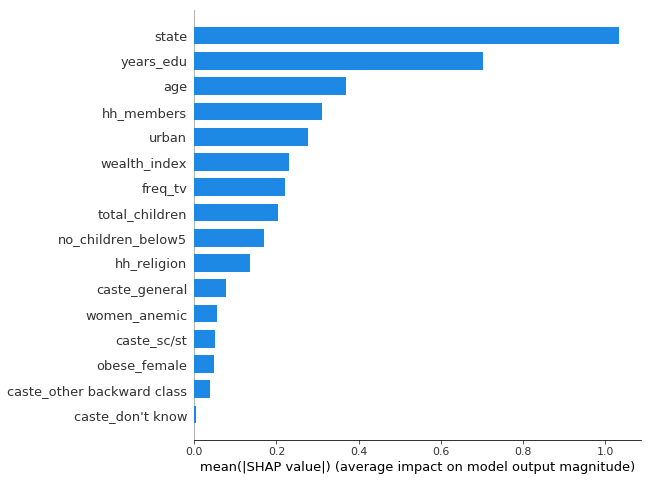

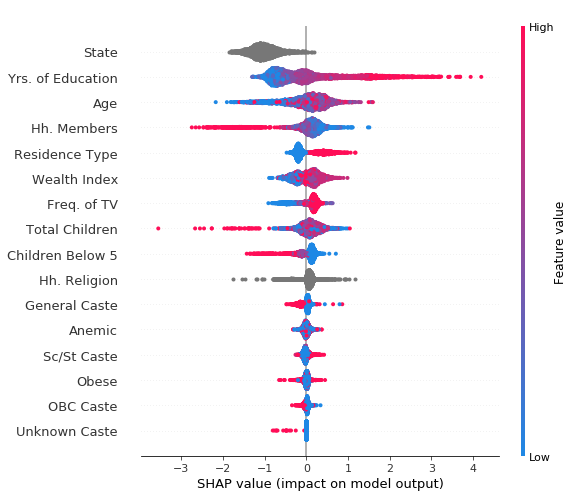


State: manipur
Sample size: 1417

state - 1.5449127872813342
wealth_index - 0.1790401717376728
hh_religion - 0.26251955073898686
women_anemic - 0.05989152362440113
obese_female - 0.04706065867927237
urban - 0.14085000991968452
freq_tv - 0.08266323272745355
age - 0.36181859886420753
years_edu - 0.794199123390254
hh_members - 0.22438804840198098
no_children_below5 - 0.12507550641821374
total_children - 0.22482044776294094
caste_don't know - 0.006467768172856759
caste_general - 0.08267890867531456
caste_other backward class - 0.052222031600413846
caste_sc/st - 0.07542223461737524


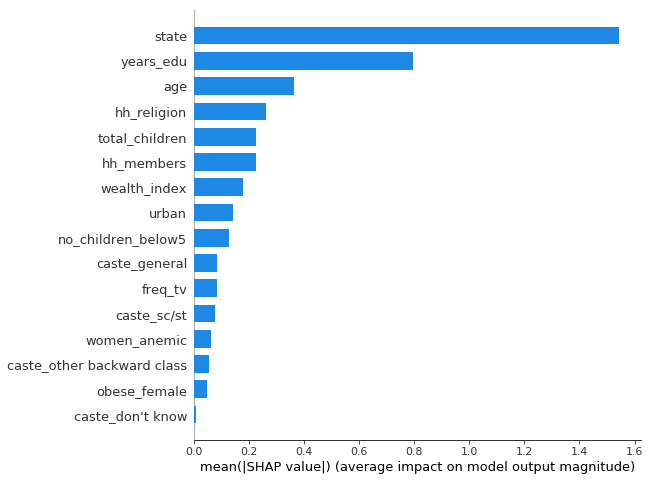

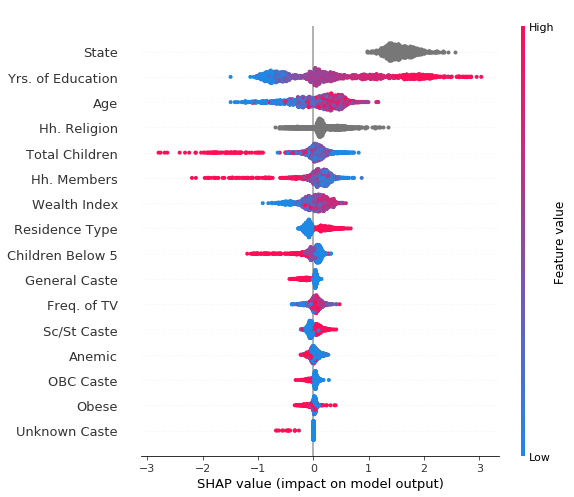


State: meghalaya
Sample size: 913

state - 1.5660293328720798
wealth_index - 0.19961449962495995
hh_religion - 0.409822557483288
women_anemic - 0.06134767139027482
obese_female - 0.04801266586807566
urban - 0.14450986468653798
freq_tv - 0.0820505823986712
age - 0.38805967549431153
years_edu - 0.8209227323940808
hh_members - 0.18133466147764718
no_children_below5 - 0.11812256720599444
total_children - 0.29173476376079516
caste_don't know - 0.0012214695682299488
caste_general - 0.050787823677593734
caste_other backward class - 0.04330078371836029
caste_sc/st - 0.09079251488088204


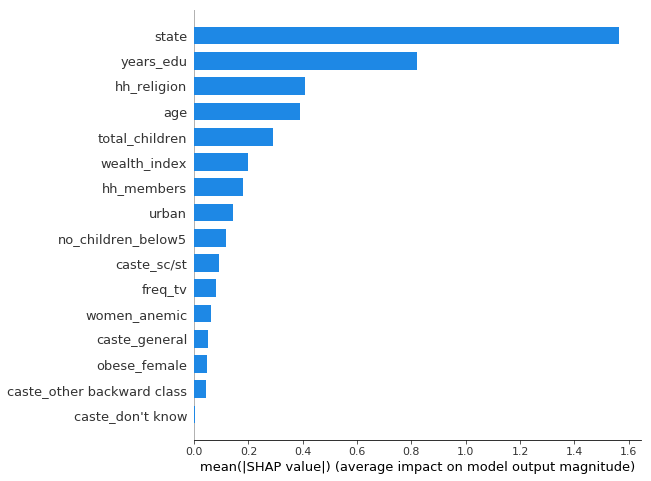

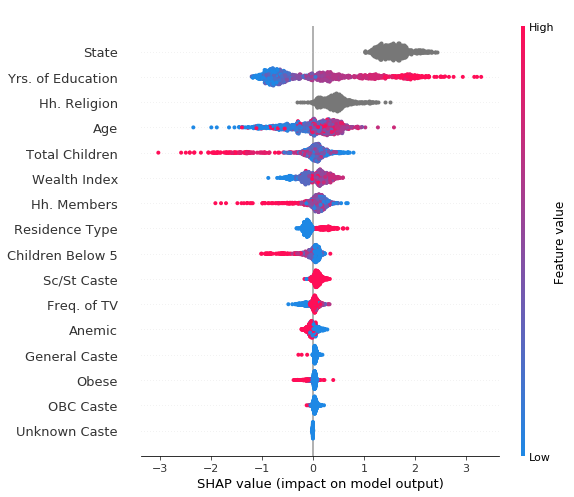


State: mizoram
Sample size: 1407

state - 1.3973389062276125
wealth_index - 0.19673731591016613
hh_religion - 0.5360015343195798
women_anemic - 0.05416113999046579
obese_female - 0.046036634074745154
urban - 0.19294356817060088
freq_tv - 0.06637494859722066
age - 0.3441168244055444
years_edu - 0.6226471562084926
hh_members - 0.18242770380834797
no_children_below5 - 0.11661349063164732
total_children - 0.1996826928507869
caste_don't know - 0.002504389552788291
caste_general - 0.04555429853467329
caste_other backward class - 0.04323817952674253
caste_sc/st - 0.08795804490142398


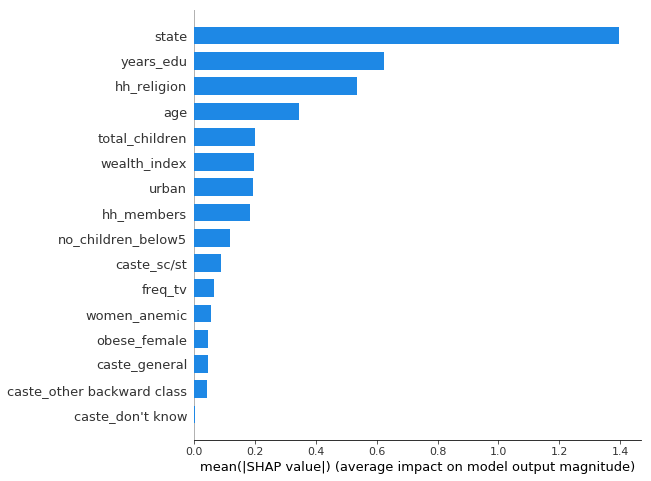

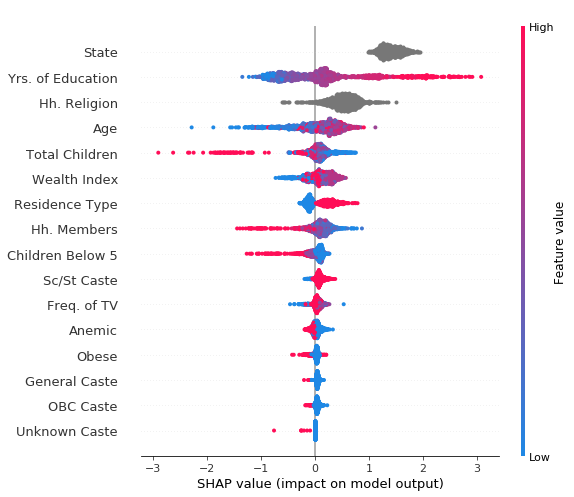


State: nagaland
Sample size: 1157

state - 1.3342058872584597
wealth_index - 0.22067411100201992
hh_religion - 0.41389496100661927
women_anemic - 0.06082225143579266
obese_female - 0.04569558336725342
urban - 0.15332174846492533
freq_tv - 0.10181411300692886
age - 0.3374221533905995
years_edu - 0.7001061829194073
hh_members - 0.1756978951901552
no_children_below5 - 0.11934422942988113
total_children - 0.3022698672682279
caste_don't know - 0.0014350163765162655
caste_general - 0.04597477502620611
caste_other backward class - 0.048992115979021825
caste_sc/st - 0.08377807169049832


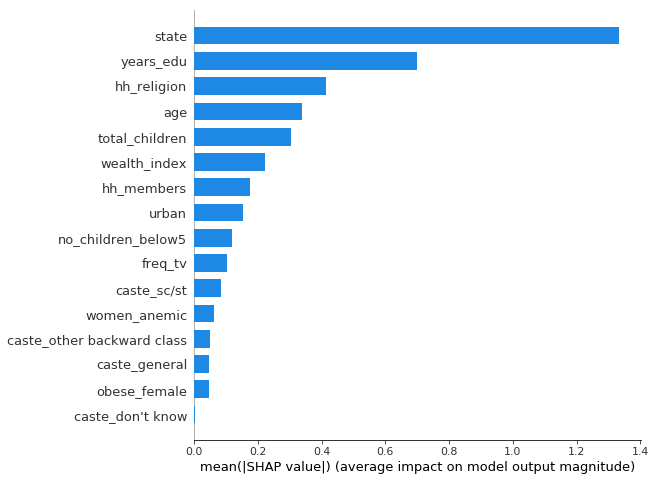

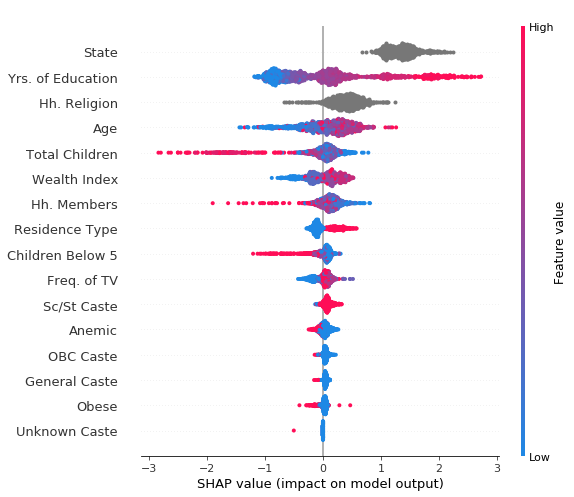


State: delhi
Sample size: 485

state - 0.21267093453913305
wealth_index - 0.16714352759589954
hh_religion - 0.1862086718789036
women_anemic - 0.050187599963413945
obese_female - 0.06012890111610632
urban - 0.22072879821151697
freq_tv - 0.07318542704837629
age - 0.34547790682072305
years_edu - 0.8166509100408065
hh_members - 0.31005998078578867
no_children_below5 - 0.14170754196196797
total_children - 0.23805395561657075
caste_don't know - 0.012544717778288033
caste_general - 0.061885037106561576
caste_other backward class - 0.04944701131607348
caste_sc/st - 0.04757466714631369


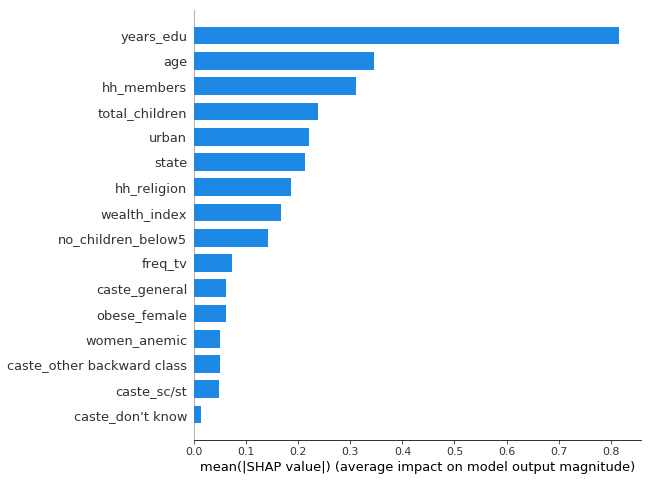

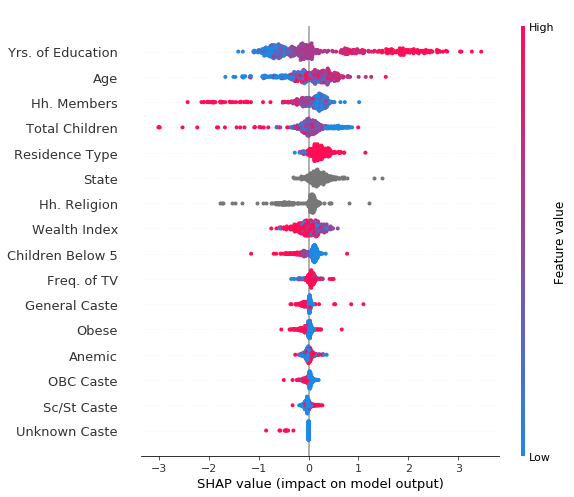


State: odisha
Sample size: 3864

state - 0.4366480850693206
wealth_index - 0.23129128282130254
hh_religion - 0.09867497975127235
women_anemic - 0.05964194207296101
obese_female - 0.05394584279276049
urban - 0.13083474507725076
freq_tv - 0.08586280232368175
age - 0.3757085725385409
years_edu - 0.6308751786948391
hh_members - 0.24746417092963457
no_children_below5 - 0.1358551735729418
total_children - 0.22682011565493407
caste_don't know - 0.002380465393742564
caste_general - 0.05791920222172097
caste_other backward class - 0.046979142889602685
caste_sc/st - 0.057244289373594534


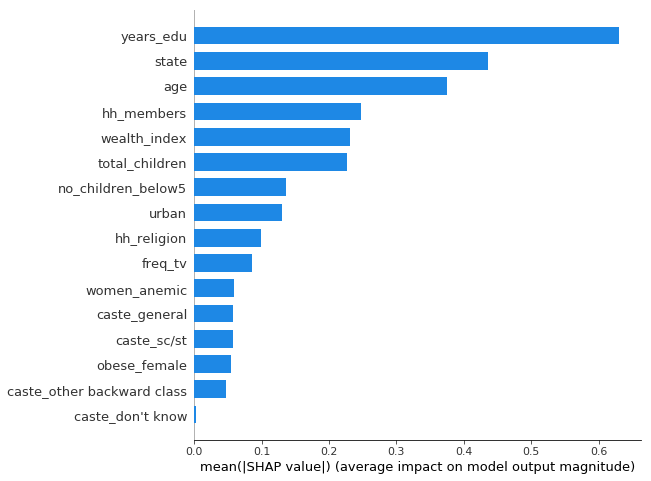

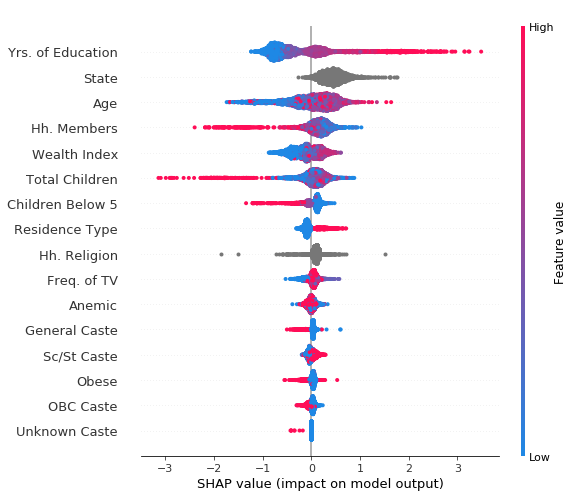


State: puducherry
Sample size: 645

state - 0.1560060693898846
wealth_index - 0.18122377397518294
hh_religion - 0.1200610160711725
women_anemic - 0.04238892840246235
obese_female - 0.06189100499635904
urban - 0.19159897192808834
freq_tv - 0.10661252467112699
age - 0.3596365885531877
years_edu - 0.8125120574425517
hh_members - 0.2539155435048267
no_children_below5 - 0.1525978296916357
total_children - 0.18491733696511384
caste_don't know - 0.003047690395646796
caste_general - 0.03849341268030372
caste_other backward class - 0.04676777216265298
caste_sc/st - 0.04154579049780569


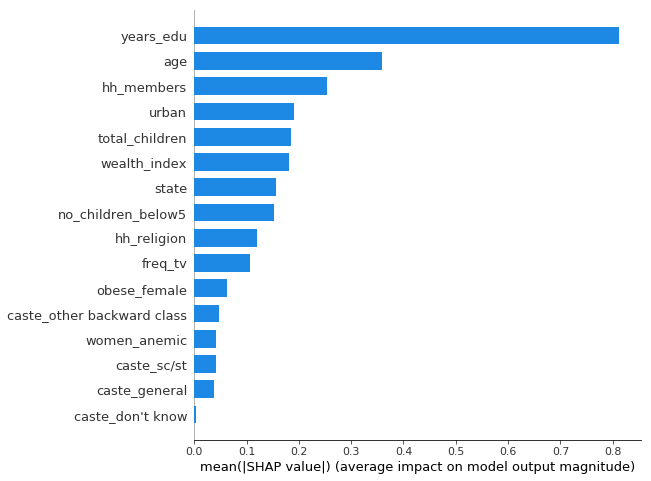

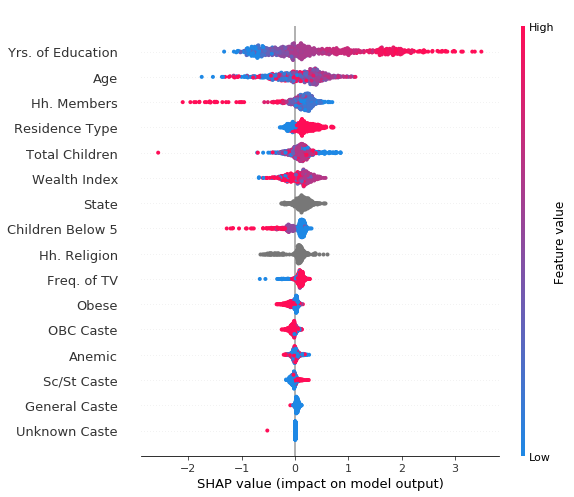


State: punjab
Sample size: 2319

state - 0.1309207317509681
wealth_index - 0.16325437802042997
hh_religion - 0.9729187557349929
women_anemic - 0.04584283619662451
obese_female - 0.15746913104145535
urban - 0.14339218485256083
freq_tv - 0.11270190427999548
age - 0.39812921473384877
years_edu - 0.9122538175830347
hh_members - 0.22908676026950253
no_children_below5 - 0.1428048190999077
total_children - 0.21905102870315032
caste_don't know - 0.0019202031035245968
caste_general - 0.06619837301768489
caste_other backward class - 0.07232809160463918
caste_sc/st - 0.0624804238525814


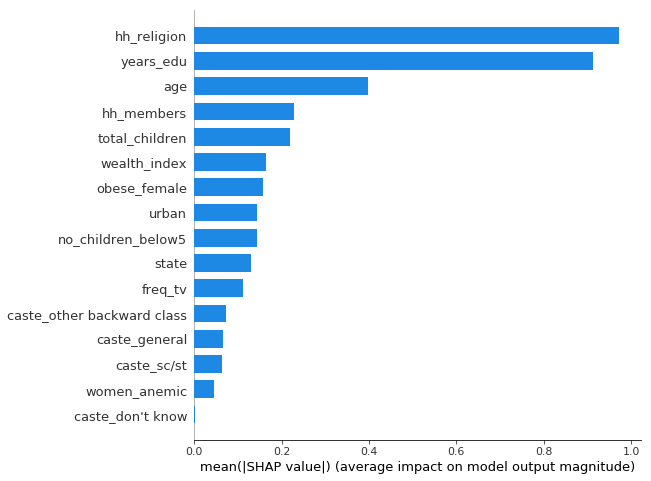

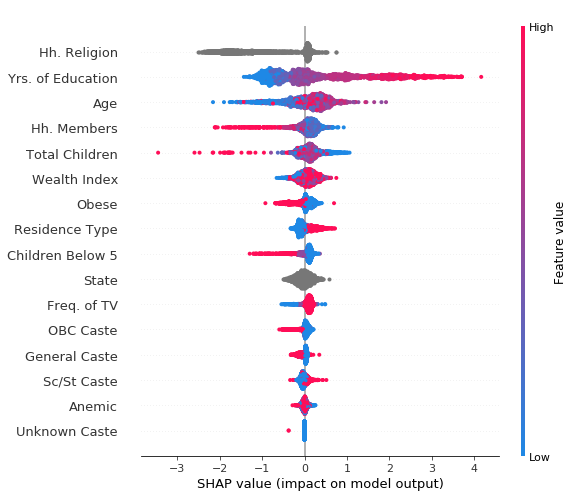


State: rajasthan
Sample size: 4556

state - 0.15854795471709854
wealth_index - 0.20864007008365548
hh_religion - 0.1451653296785034
women_anemic - 0.055368303296675456
obese_female - 0.04763396419527993
urban - 0.16250190163719158
freq_tv - 0.12409935063795383
age - 0.4052929044489451
years_edu - 0.7918928856545001
hh_members - 0.31821871527824913
no_children_below5 - 0.16676688459429592
total_children - 0.3535429088059606
caste_don't know - 0.003468117571994088
caste_general - 0.05825744022937626
caste_other backward class - 0.0368153698421929
caste_sc/st - 0.04653914095117195


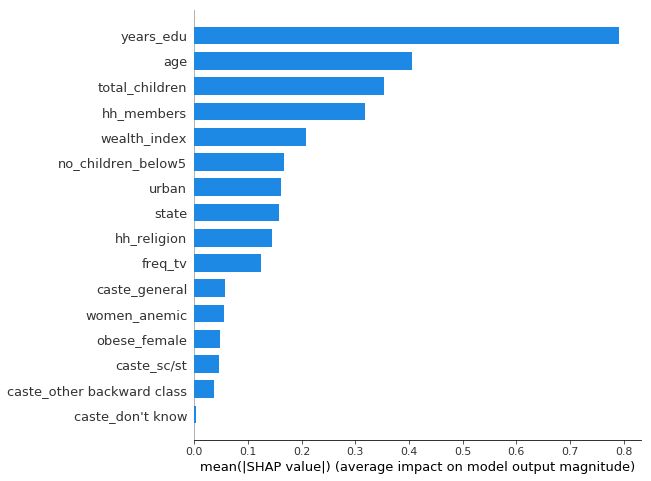

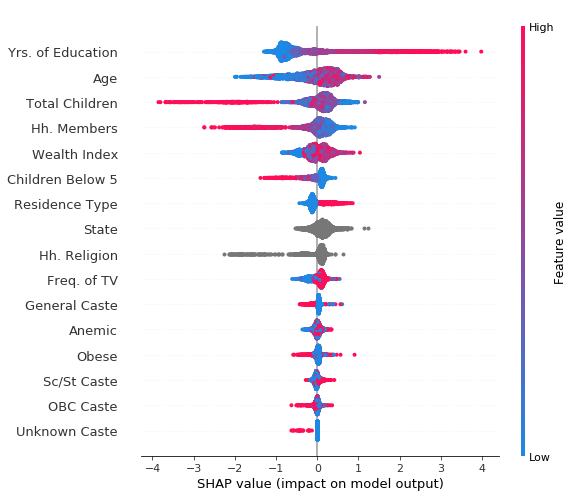


State: sikkim
Sample size: 707

state - 0.22717297641111467
wealth_index - 0.2144282934229581
hh_religion - 0.15209625295680554
women_anemic - 0.05922641699651049
obese_female - 0.06193085377058638
urban - 0.1804574135945736
freq_tv - 0.09272610250993675
age - 0.37913647800952394
years_edu - 0.8037686765121645
hh_members - 0.2062285329125742
no_children_below5 - 0.09315798266214063
total_children - 0.24116136110427452
caste_don't know - 0.0013653603680555267
caste_general - 0.05944508950071662
caste_other backward class - 0.030041591996918124
caste_sc/st - 0.055379949585040535


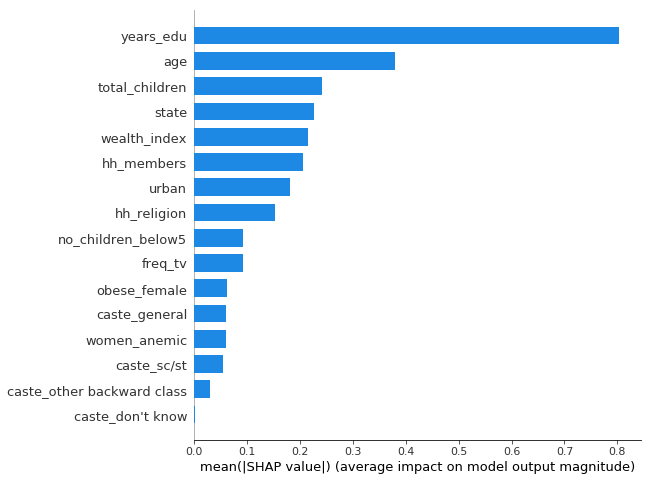

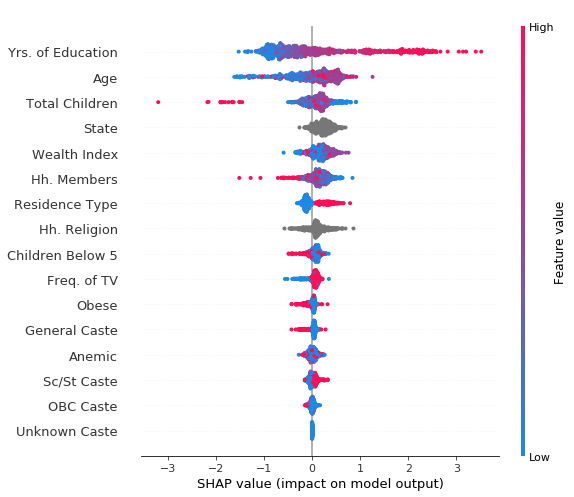


State: tamil nadu
Sample size: 4656

state - 0.192987675496076
wealth_index - 0.19637995690374863
hh_religion - 0.12329422260737495
women_anemic - 0.06732850149569387
obese_female - 0.05898437002186814
urban - 0.17008924467020917
freq_tv - 0.08924650734065354
age - 0.3839150140766891
years_edu - 0.7674562631830993
hh_members - 0.24464731397430725
no_children_below5 - 0.1366375987553661
total_children - 0.25000544195714736
caste_don't know - 0.0021369935184740803
caste_general - 0.044843768458712865
caste_other backward class - 0.04238057056171841
caste_sc/st - 0.0441525142513553


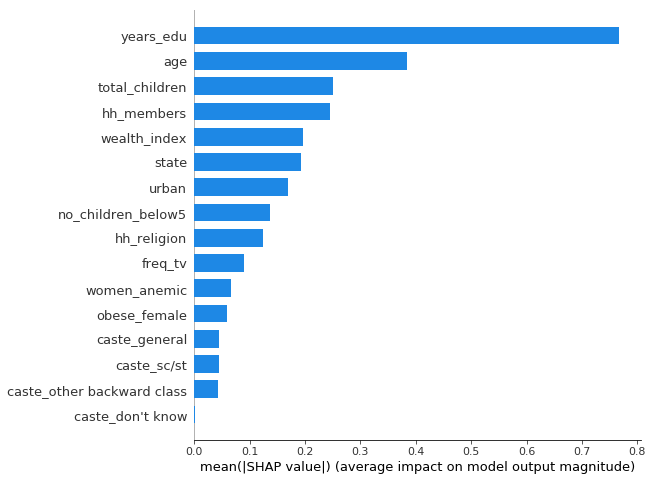

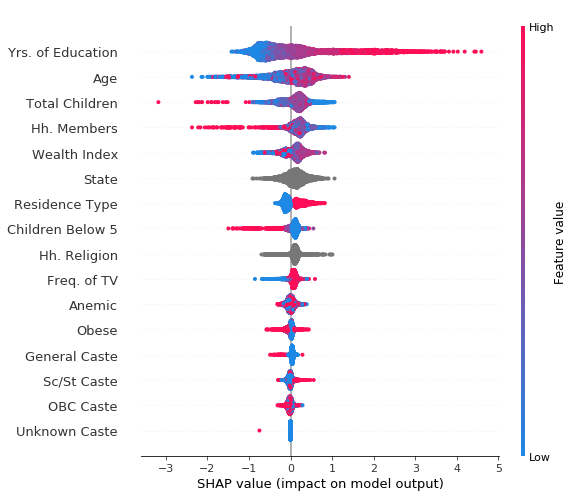


State: tripura
Sample size: 606

state - 0.12727356002531132
wealth_index - 0.19811263317187433
hh_religion - 0.1045062172228513
women_anemic - 0.07176007340804344
obese_female - 0.051888405462734884
urban - 0.18447182184082253
freq_tv - 0.0885098182655911
age - 0.36137900374372534
years_edu - 0.5589648840409499
hh_members - 0.25518710876817563
no_children_below5 - 0.11398310096677475
total_children - 0.20616494766161925
caste_don't know - 0.001736829114685215
caste_general - 0.060623090381840085
caste_other backward class - 0.029573292982143416
caste_sc/st - 0.05042432048217858


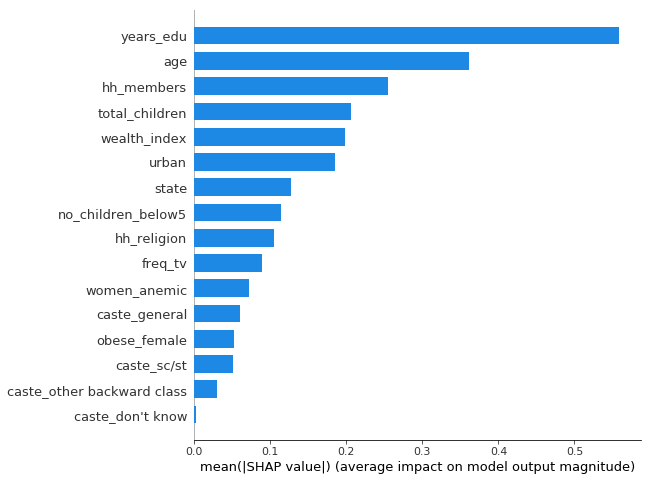

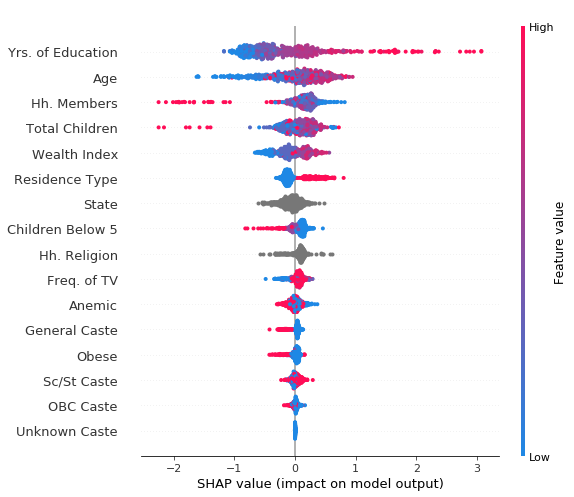


State: uttar pradesh
Sample size: 9903

state - 0.4771570535825865
wealth_index - 0.25262565661151015
hh_religion - 0.13867015610508343
women_anemic - 0.08444548605041632
obese_female - 0.06552339690557166
urban - 0.17548402161509052
freq_tv - 0.14157805987745078
age - 0.38264199138982413
years_edu - 0.8516267173698873
hh_members - 0.3950939947867181
no_children_below5 - 0.18294960166048888
total_children - 0.41712508250249597
caste_don't know - 0.0021416641968204056
caste_general - 0.06512074544485849
caste_other backward class - 0.04617562821260139
caste_sc/st - 0.04747003528389601


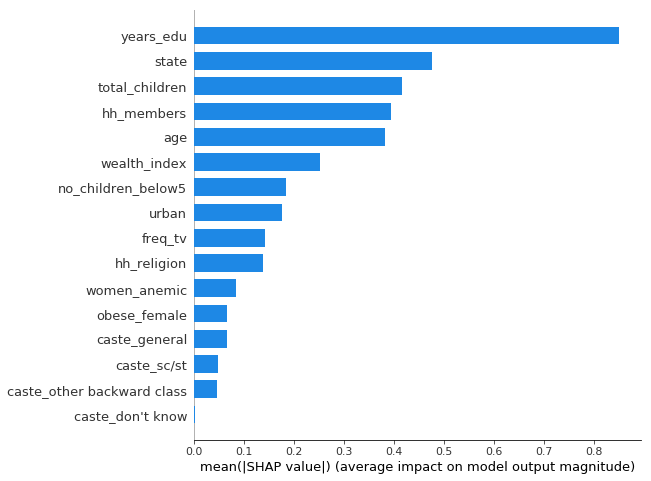

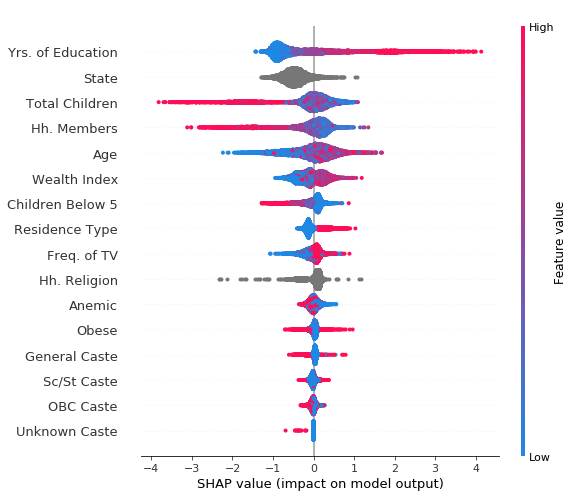


State: uttarakhand
Sample size: 1867

state - 0.614490521083587
wealth_index - 0.20816198513362352
hh_religion - 0.14807841334027902
women_anemic - 0.06274399631857054
obese_female - 0.05842460532174856
urban - 0.16825631442435077
freq_tv - 0.19254820961180213
age - 0.37250718881279954
years_edu - 0.8877075363433696
hh_members - 0.27790080571254056
no_children_below5 - 0.16385954920084722
total_children - 0.2942942281706728
caste_don't know - 0.0038055998742849984
caste_general - 0.09512058730361136
caste_other backward class - 0.038549002192153604
caste_sc/st - 0.04728616438442377


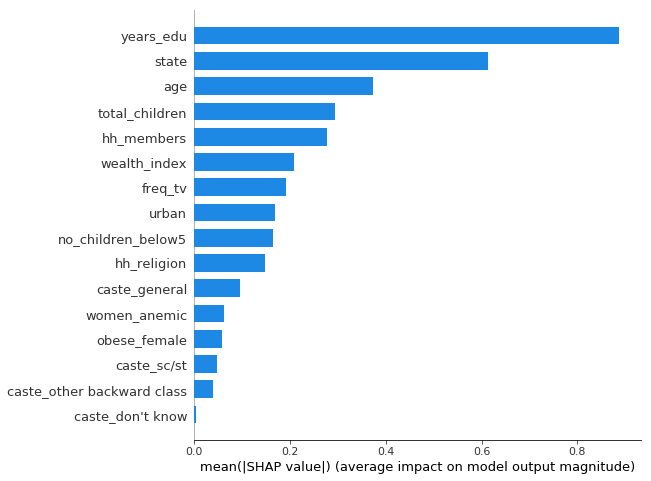

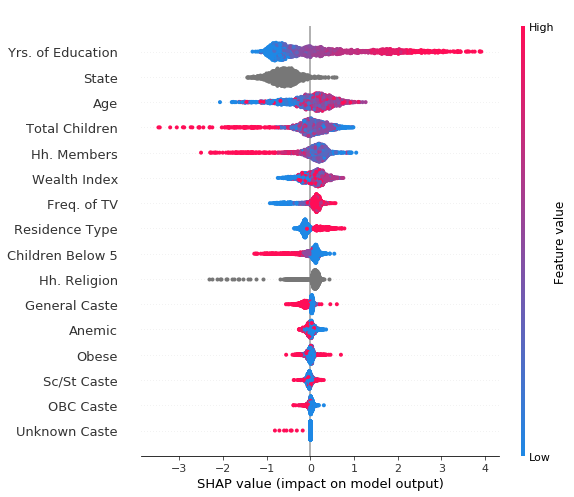


State: west bengal
Sample size: 1706

state - 0.902066897574428
wealth_index - 0.25569125910239554
hh_religion - 0.17708754637177218
women_anemic - 0.0821452902041435
obese_female - 0.06448177581741904
urban - 0.18043624278414988
freq_tv - 0.27112787863061305
age - 0.36945027573001193
years_edu - 0.7068519762492869
hh_members - 0.27898257935078924
no_children_below5 - 0.16711071602573724
total_children - 0.26055055153441636
caste_don't know - 0.005884781045944744
caste_general - 0.08701561609060367
caste_other backward class - 0.03644525707019138
caste_sc/st - 0.05152002148689131


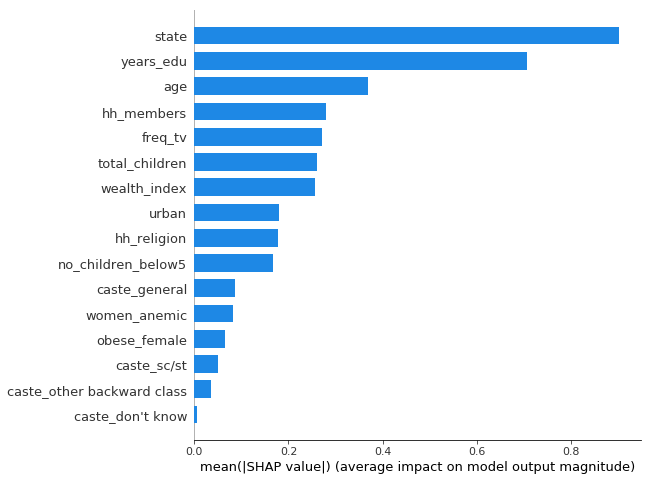

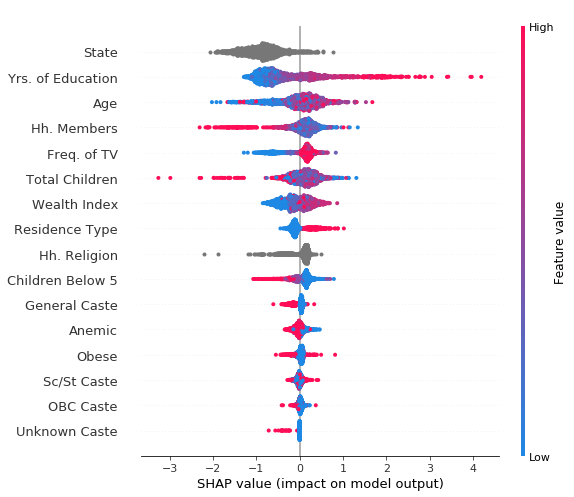


State: telangana
Sample size: 885

state - 0.8405288626052192
wealth_index - 0.31380262798911535
hh_religion - 0.14305201701105166
women_anemic - 0.06831449172976366
obese_female - 0.05448262463897279
urban - 0.1391801333954435
freq_tv - 0.2436088164201
age - 0.4132797118727881
years_edu - 0.8686223840131839
hh_members - 0.24679991841588914
no_children_below5 - 0.22280916695302558
total_children - 0.3358030458533456
caste_don't know - 0.00393513000475179
caste_general - 0.056442743749605985
caste_other backward class - 0.04446905368766642
caste_sc/st - 0.04654000340844866


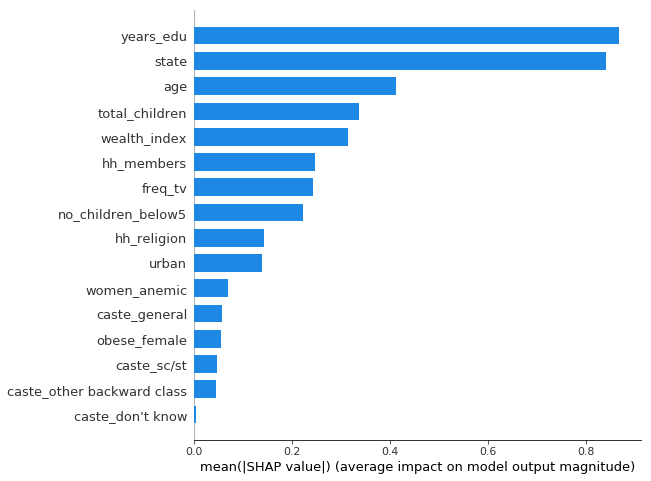

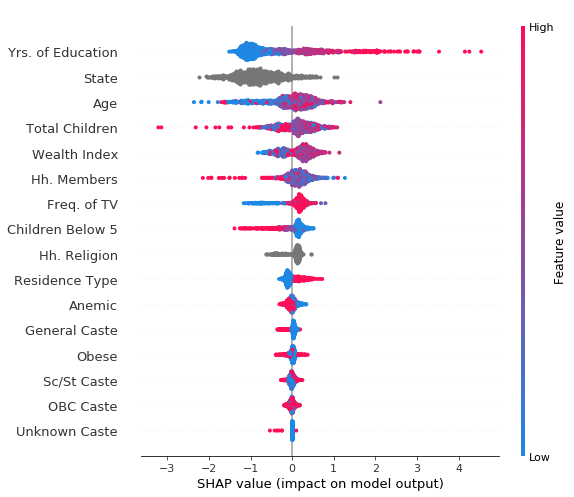

In [36]:
for state, state_display in zip(dataset.state.unique(), dataset_display.State.unique()):
    # Sample dataset by state
    dataset_sample = dataset[dataset.state==state]
    dataset_display_sample = dataset_display[dataset.state==state]
    targets_sample = targets[dataset.state==state]
    shap_values_sample = shap_values[dataset.state==state]
    
    print("\nState: {}".format(state_display))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. 

The model returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. 

Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [43]:
# Sample from dataset based on sample weights
dataset_ss = dataset.sample(10000, weights=sample_weights, random_state=random_state)
print(dataset_ss.shape)
dataset_display_ss = dataset_display.loc[dataset_ss.index]
print(dataset_display_ss.shape)

(10000, 16)
(10000, 16)


In [44]:
# Compute SHAP interaction values (time consuming)
# shap_interaction_values = explainer.shap_interaction_values(dataset_ss)
shap_interaction_values = pickle.load(open(f'res/{target_col}-{year}-shapints.obj', 'rb'))

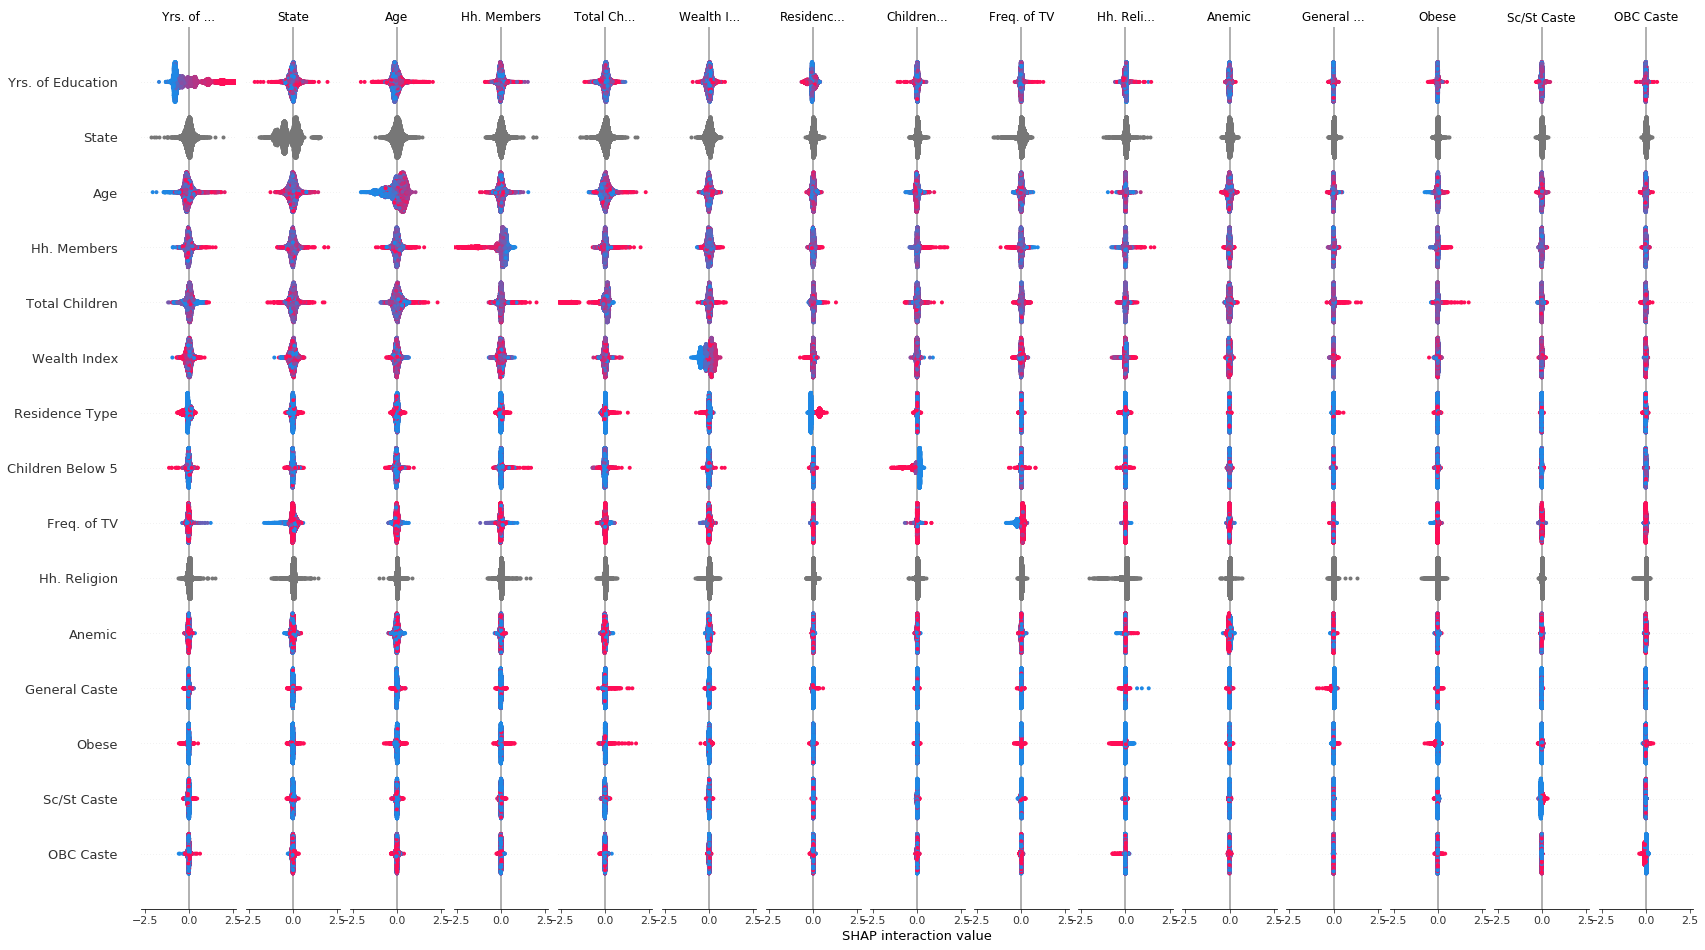

In [45]:
shap.summary_plot(shap_interaction_values, dataset_display_ss, max_display=15)

### Heatmap of SHAP Interaction Values

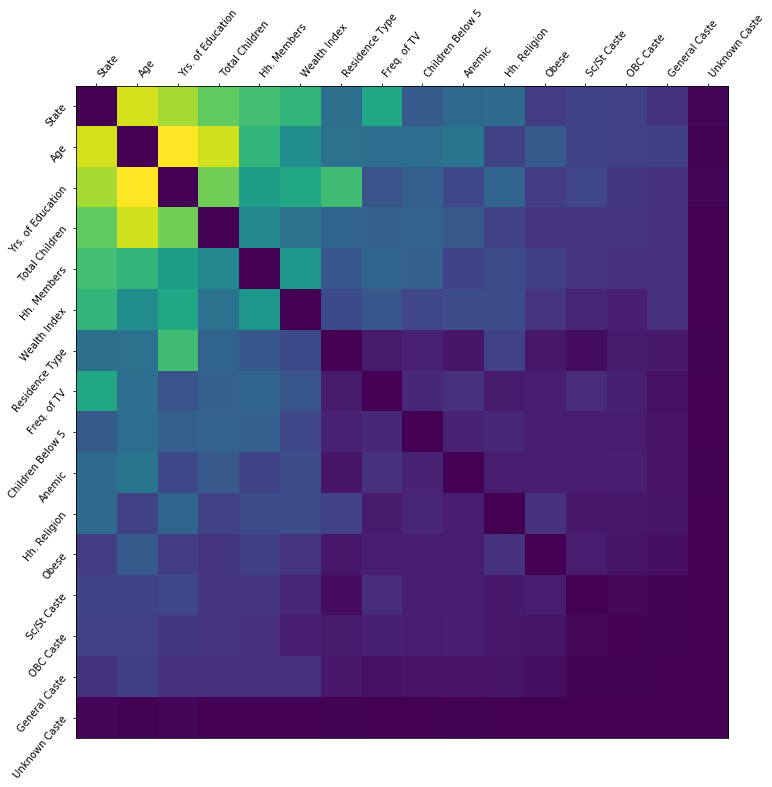

In [46]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

**Good example of how to infer interesting stuff from interaction values: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html**

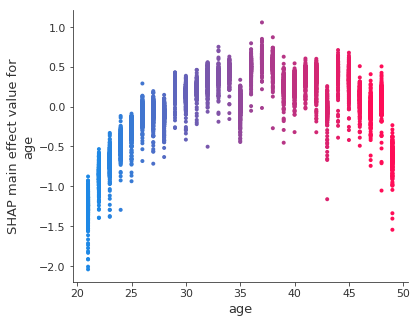

In [47]:
shap.dependence_plot(
    ("age", "age"), 
    shap_interaction_values, dataset_ss, display_features=dataset_display_ss
)

Now we plot the interaction effects involving age (and other features after that). These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above.

#### Plots for 'age'


Feature: age, Interaction Feature: age


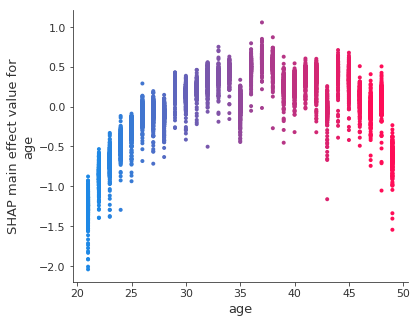


Feature: age, Interaction Feature: urban


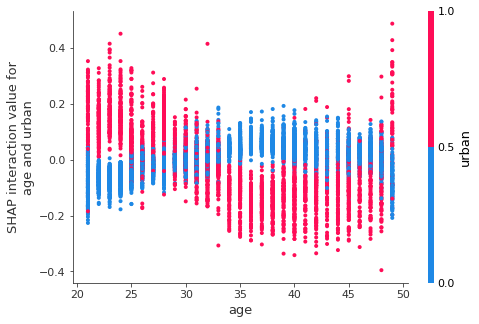


Feature: age, Interaction Feature: caste_sc/st


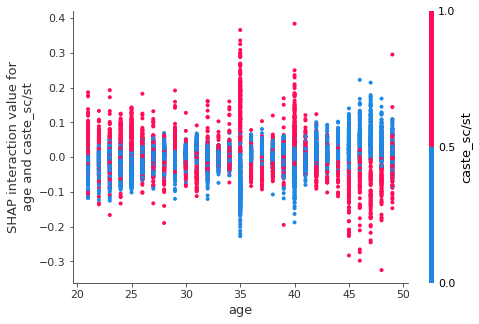


Feature: age, Interaction Feature: caste_general


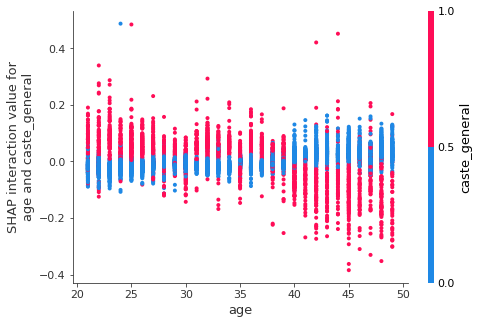


Feature: age, Interaction Feature: wealth_index


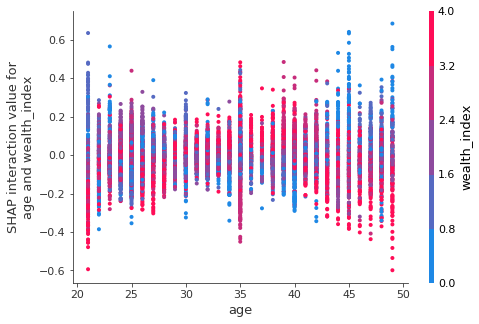


Feature: age, Interaction Feature: years_edu


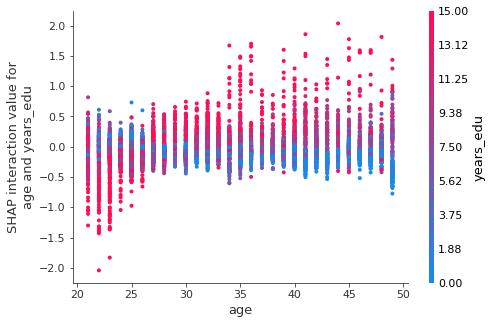


Feature: age, Interaction Feature: no_children_below5


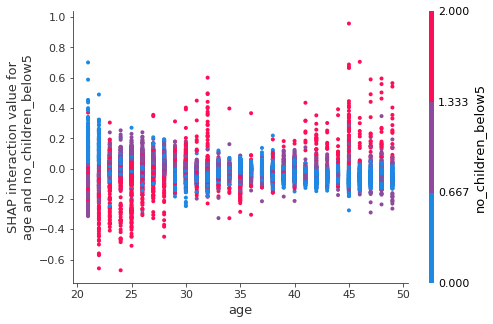


Feature: age, Interaction Feature: total_children


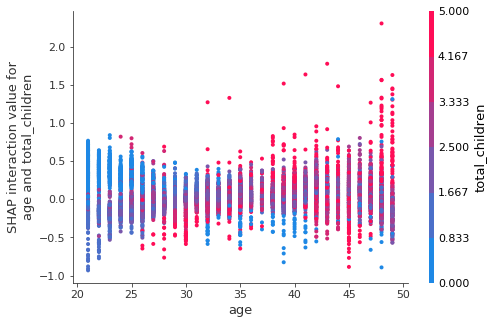

In [48]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


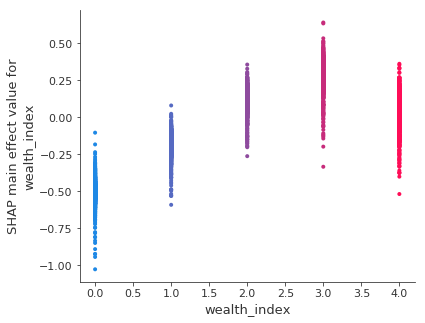


Feature: wealth_index, Interaction Feature: age


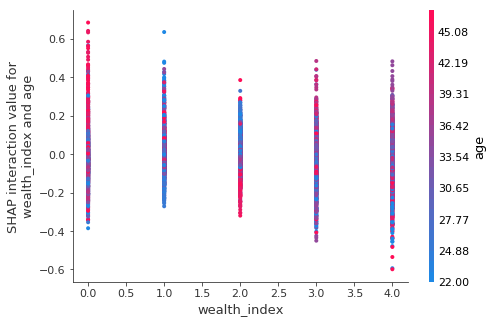


Feature: wealth_index, Interaction Feature: urban


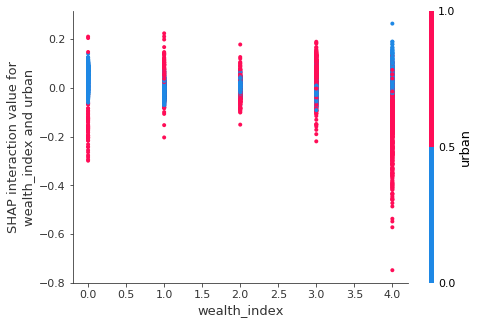


Feature: wealth_index, Interaction Feature: caste_sc/st


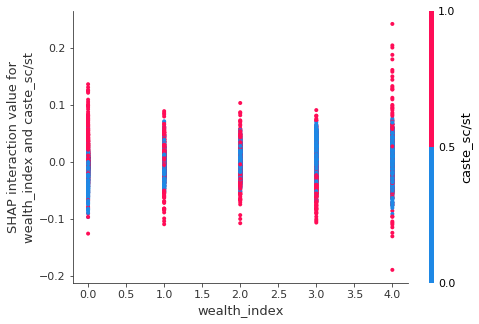


Feature: wealth_index, Interaction Feature: caste_general


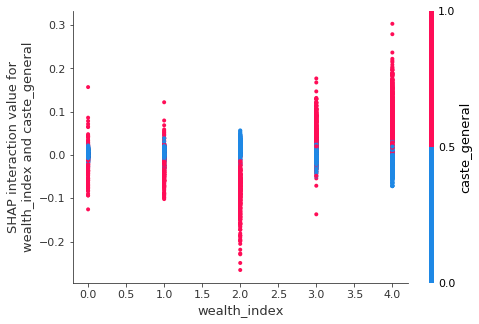


Feature: wealth_index, Interaction Feature: years_edu


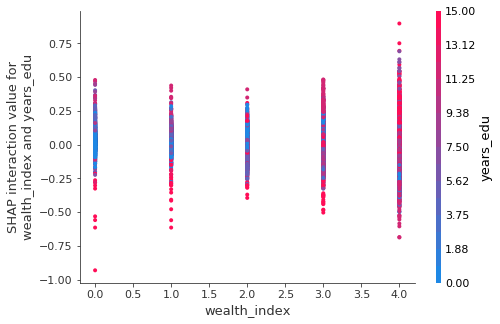


Feature: wealth_index, Interaction Feature: no_children_below5


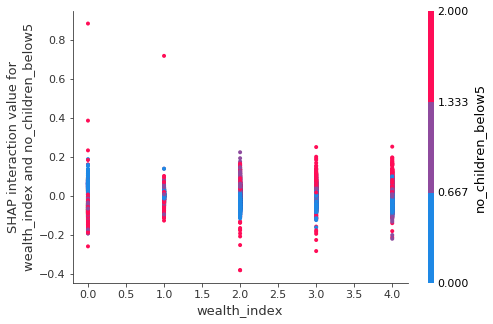


Feature: wealth_index, Interaction Feature: total_children


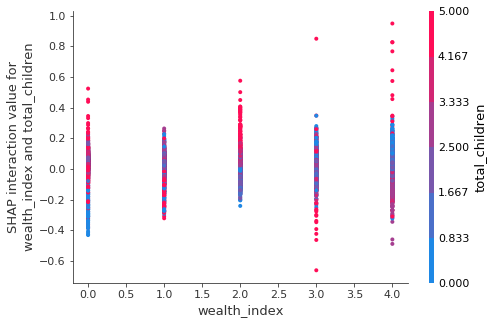

In [49]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


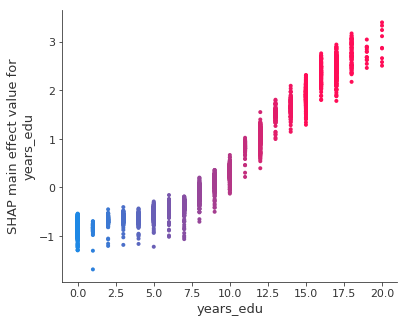


Feature: years_edu, Interaction Feature: age


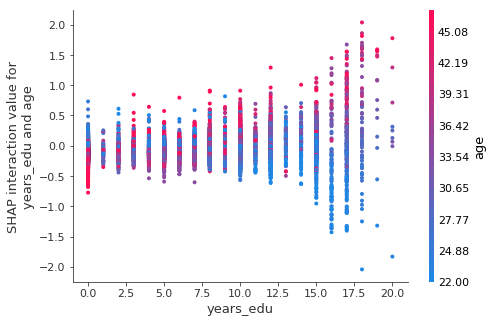


Feature: years_edu, Interaction Feature: urban


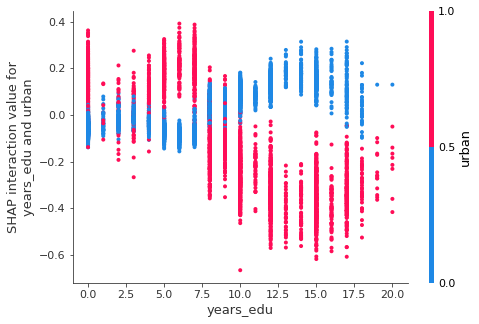


Feature: years_edu, Interaction Feature: caste_sc/st


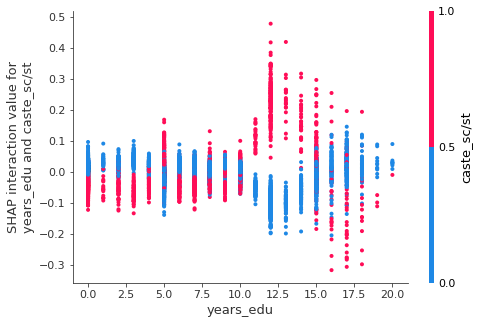


Feature: years_edu, Interaction Feature: caste_general


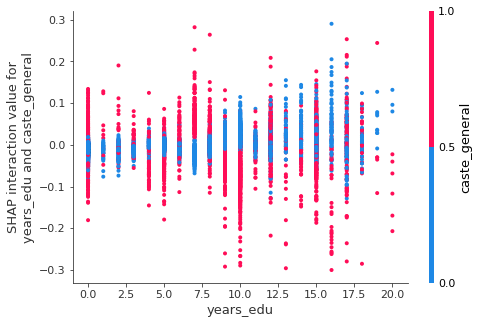


Feature: years_edu, Interaction Feature: wealth_index


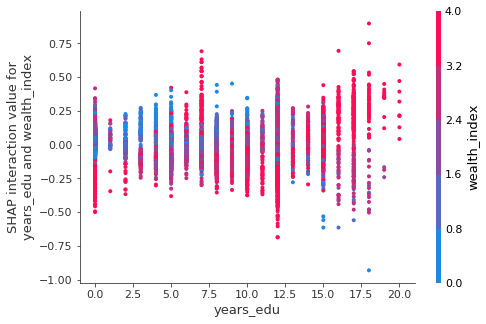


Feature: years_edu, Interaction Feature: no_children_below5


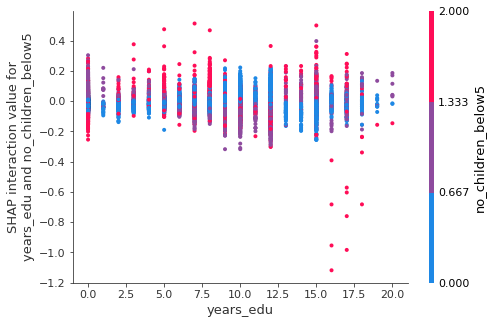


Feature: years_edu, Interaction Feature: total_children


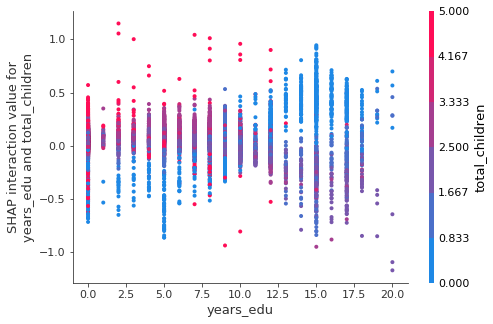

In [50]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


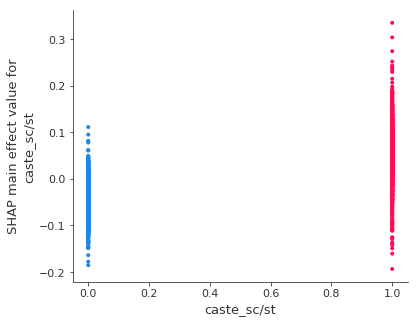


Feature: caste_sc/st, Interaction Feature: age


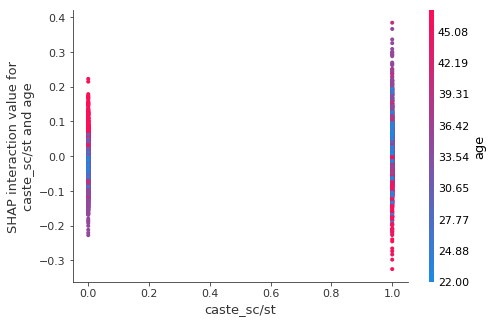


Feature: caste_sc/st, Interaction Feature: urban


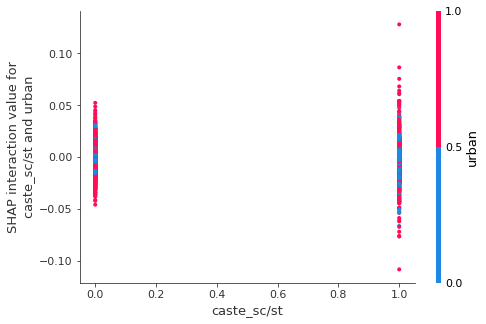


Feature: caste_sc/st, Interaction Feature: years_edu


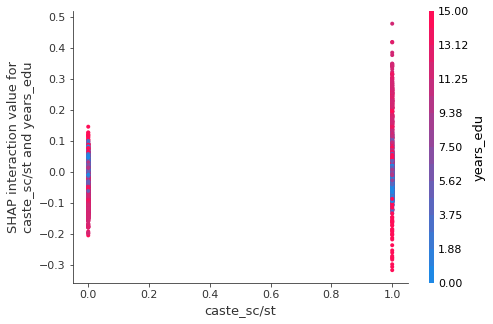


Feature: caste_sc/st, Interaction Feature: wealth_index


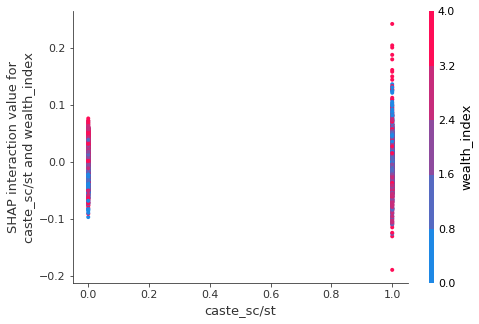


Feature: caste_sc/st, Interaction Feature: no_children_below5


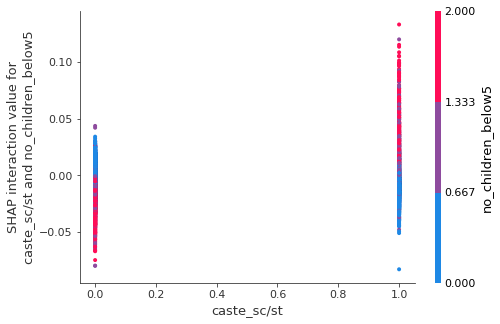


Feature: caste_sc/st, Interaction Feature: total_children


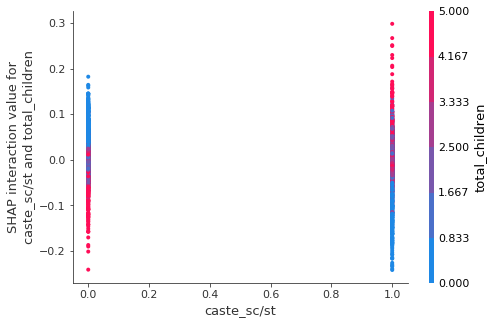

In [51]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


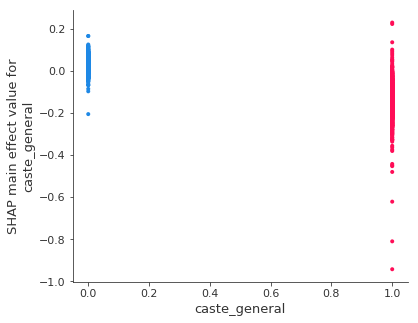


Feature: caste_general, Interaction Feature: age


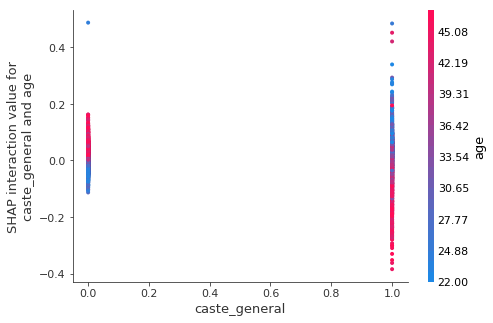


Feature: caste_general, Interaction Feature: urban


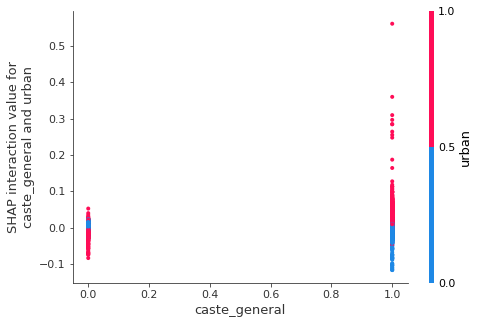


Feature: caste_general, Interaction Feature: years_edu


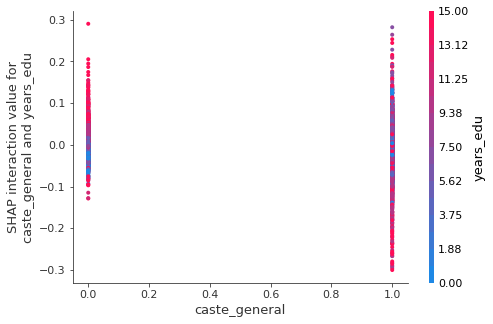


Feature: caste_general, Interaction Feature: wealth_index


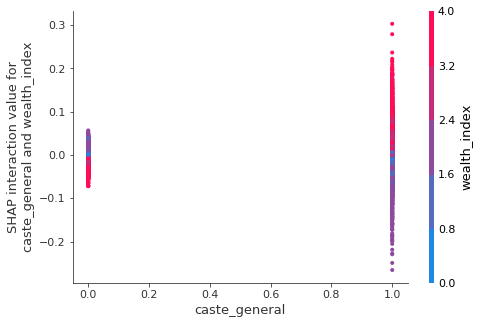


Feature: caste_general, Interaction Feature: no_children_below5


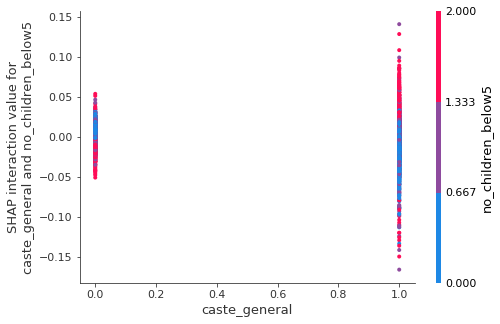


Feature: caste_general, Interaction Feature: total_children


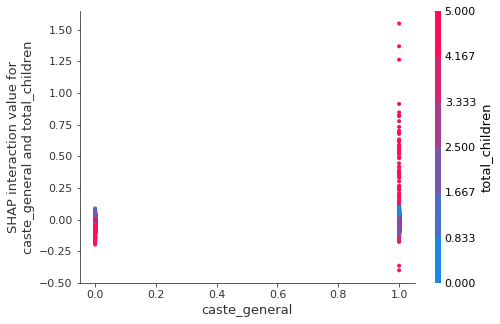

In [52]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )